In [ ]:
"""
For licensing see accompanying LICENSE file.
Copyright (C) 2023 Apple Inc. All Rights Reserved.
"""

import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import os
from pathlib import Path
os.makedirs('out', exist_ok=True)
directory = DIRECTORY = Path('./data')

In [66]:
df = pd.read_csv(DIRECTORY / 'results.csv')
df['val'] = df['val'].astype(float)
df['amount'] = df['amount'].astype(float)
models = list(sorted(set(df['model'].unique())))
import numpy as np

data = []
for model in models:
    differences = []
    for heuristic in df['heuristic'].unique():
        for amount in df['amount'].unique():
            if amount > 0.4:
                continue
            condition = (df['model'] == model) * (df['side'] == 'input') * (df['heuristic'] == heuristic) * (df['amount'] == amount)
            rows = df[condition]
            if len(rows.index) == 2:
                differences.append(rows[rows['method'] == 'unconstrained']['val'].item() - rows[rows['method'] == 'constrained']['val'].item())
    data.append({'model': model, 'acc': np.mean(differences) * 100.0})

# Main Paper

## Statistics

In [88]:
df = pd.read_csv(DIRECTORY / 'results.csv')
df = df.sort_values(by='amount')
method_to_accs = {'unconstrained': [], 'constrained': []}
models = list(sorted(set(df['model'].unique())))
heuristics = list(sorted(df['heuristic'].unique()))
df['amount'] = df['amount'].astype(float)
df['val'] = df['val'].astype(float)

biggest_diff = 0

# df[(df['model'] == 'efficientnet_v2_s') * (df['heuristic'] == 'lamp') * (df['side'] == 'input')]

for heuristic in heuristics:
    for model in models:
        condition =  (df['model'] == model) * (df['heuristic'] == heuristic) * (df['side'] == 'input')
        for method in ('unconstrained', 'constrained'):
            method_to_accs[method].append(df[
                (df['model'] == model)
                 * (df['heuristic'] == heuristic)
                  * (df['side'] == 'input')
                  * (df['method'] == method)
            ]['val'].mean())
        # biggest_diff = max(biggest_diff, differences.max())
for method in method_to_accs:
    import numpy as np
    print(method, np.mean(method_to_accs[method]))
differences = [u - c for u, c in zip(method_to_accs['unconstrained'], method_to_accs['constrained'])]
max(differences), min(differences), models[np.argmax(differences) % len(models)], heuristics[np.argmax(differences) // len(models)]
# 0.18803086955912407 - 0.16687695452889065

unconstrained 0.18803086955912407
constrained 0.16687695452889065


(0.21702705006635586, -0.09117528749629858, 'densenet121', 'l1')

In [68]:
models = [model for model in list(sorted(set(df['model'].unique()))) if 'efficient' not in model and 'mnasnet0' not in model and 'wide' not in model]
heuristics = list(sorted(df['heuristic'].unique()))
df['gpu_latency_mean'] = df['gpu_latency_mean'].astype(float)
df['gpu_naive_latency_mean'] = df['gpu_naive_latency_mean'].astype(float)
differences = []
method_to_latencies = {'ours': [], 'naive': []}
for heuristic in heuristics:
    for model in models:
        condition =  (df['model'] == model) * (df['heuristic'] == heuristic) * (df['side'] == 'input') * (df['method'] == 'unconstrained')
        method_to_latencies['ours'].append(df[condition]['gpu_latency_mean'].mean())
        method_to_latencies['naive'].append(df[condition]['gpu_naive_latency_mean'].mean())
        maximum = ((df[condition]['gpu_naive_latency_mean'] - df[condition]['gpu_latency_mean']) / df[condition]['gpu_latency_mean']).max()
        differences.append( maximum.item() )
        # if maximum.item() == 0.5281362932369643:
        #     print(model, heuristic)
for method in method_to_latencies:
    import numpy as np
    print(method, np.mean(list(filter(lambda x: not np.isnan(x), method_to_latencies[method]))))
differences = [(n - o) / o for n, o in zip(method_to_latencies['naive'], method_to_latencies['ours'])]
max(differences), min(differences), models[np.argmax(differences) % len(models)], heuristics[np.argmax(differences) // len(models)]
# (2.5359990534144687 - 2.3343535835023665) / 2.3343535835023665

ours 2.334194705882353
naive 2.55453


(0.24889888482803876, 0.01771679872454024, 'squeezenet1_1', 'l1')

## Figures

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


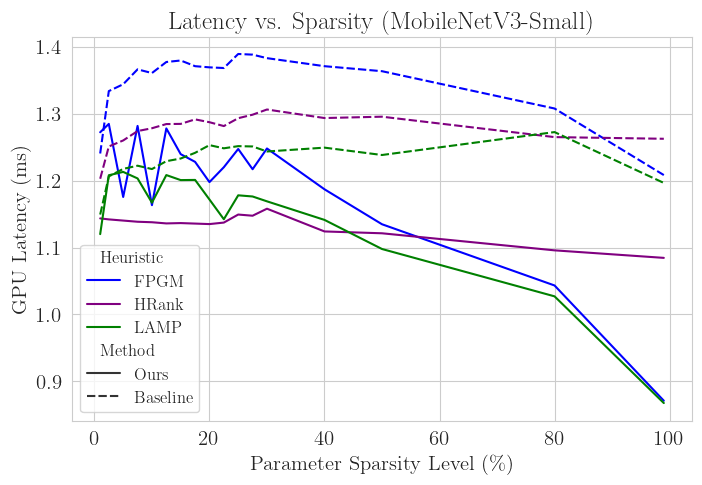

In [239]:
# plot accuracies
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.3, top=0.75)
# fig.suptitle('Latency vs. Sparsity Level with Post-Training Pruning')
size = (1, 5)
plt.legend(loc='lower left')
plt.rc('text', usetex=True)
plt.rc('font', family='invalidlol')

df = pd.read_csv(DIRECTORY / 'results.csv')

# add new rows for 'gpu_naive_latency_mean' as though it was method='naive'
_df = df[df['method'] == 'unconstrained'].copy()
_df['gpu_latency_mean'] = _df['gpu_naive_latency_mean']
_df['method'] = 'naive'
_df = pd.concat([df, _df], ignore_index=True)
_df['val'] = _df['val'] * 100.0
_df['amount'] = _df['amount'] * 100.0
_df = _df.assign(method=_df.method.map({'unconstrained': 'Ours', 'naive': 'Baseline', 'constrained': 'zero-copy'}))

_df['Heuristic'] = _df['heuristic']
_df['Method'] = _df['method']
_df = _df.replace({'fpgm': 'FPGM', 'hrank': 'HRank', 'lamp': 'LAMP'})

condition = _df['model'] == 'mobilenet_v3_small'
g = sns.lineplot(_df[condition], x='amount', y='gpu_latency_mean', palette=['blue', 'purple', 'green'], hue='Heuristic', hue_order=('FPGM', 'HRank', 'LAMP'), style='Method', style_order=('Ours', 'Baseline'), legend=True)
plt.rc('legend', fontsize=12)
plt.title('Latency vs. Sparsity (MobileNetV3-Small)')
plt.ylabel('GPU Latency (ms)')
plt.xlabel('Parameter Sparsity Level (\%)')

# # for poster
# color = (238 / 255., 238 / 255., 238 / 255.)  # eee
# fig.set_facecolor(color)
# g.set_facecolor(color)
# plt.legend().get_frame().set_facecolor(color)

plt.savefig(directory / f"figure_1_latency_vs_sparsity.pdf", bbox_inches='tight', pad_inches=0)

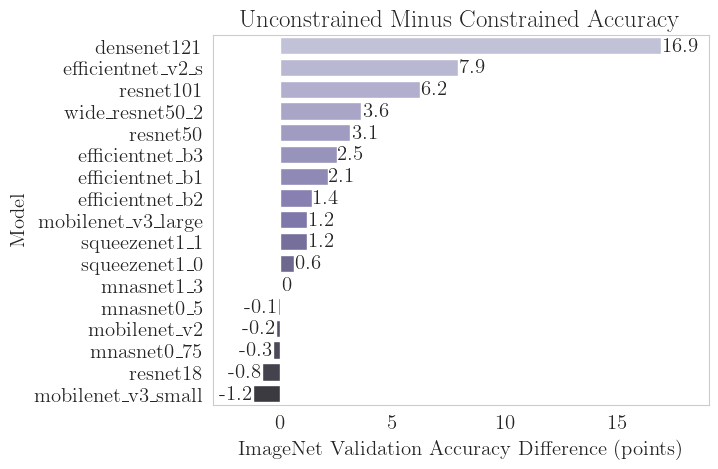

In [240]:
plt.rc('text', usetex=True)
plt.rc('font', family='invalidlol')

fig = plt.figure()

df2 = pd.DataFrame(data)
df2 = df2.sort_values(by='acc', ascending=False)
df2['acc'] = df2['acc'].round(1)
pal = sns.color_palette("Purples_d", len(data))
rank = df2['acc'].argsort()
ax = sns.barplot(data=df2, y="model", x="acc", palette=np.array(pal[::-1])[rank])
for i in ax.containers:
    ax.bar_label(i, padding=1)
ax.set_xlim(left=-3, right=19)
ax.grid(False)
plt.title('Unconstrained Minus Constrained Accuracy')
plt.ylabel('Model')
plt.xlabel('ImageNet Validation Accuracy Difference (points)')

# # for poster
# color = (238 / 255., 238 / 255., 238 / 255.)  # eee
# ax.set_facecolor(color)
# fig.set_facecolor(color)

plt.savefig(directory / 'figure_3_unconstrained_minus_constrained_acc.pdf', bbox_inches='tight', pad_inches=0)

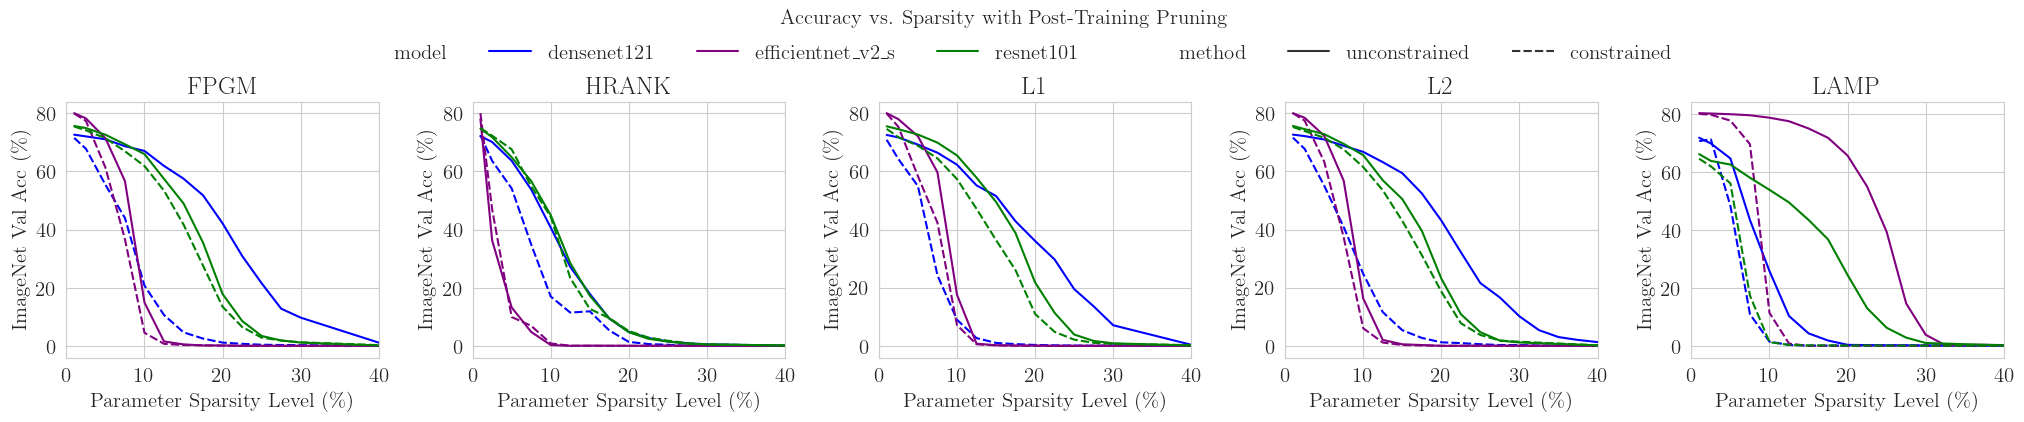

In [244]:
plt.rc('text', usetex=True)
plt.rc('font', family='invalidlol')

# plot accuracies
fig = plt.figure(figsize=(25, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.3, top=0.75)
fig.suptitle('Accuracy vs. Sparsity with Post-Training Pruning')
size = (1, 5)

models = ('densenet121', 'efficientnet_v2_s', 'resnet101')

df = pd.read_csv(DIRECTORY / 'results.csv')
heuristics = list(sorted(df['heuristic'].unique()))
for i, heuristic in enumerate(heuristics, start=1):
    ax = fig.add_subplot(*size, i)
    ax.set_xlim(0, 40)
    plt.rc('font', size=15)
    plt.rc('figure', titlesize=15)
    plt.rc('legend', fontsize=15)

    condition = (df['heuristic'] == heuristic) * (df['side'] == 'input')
    _df = df[condition].copy()
    _df['val'] = _df['val'] * 100.0
    _df['amount'] = _df['amount'] * 100.0

    sns.lineplot(_df, x='amount', y='val', hue='model', palette=['blue', 'purple', 'green'], hue_order=models, style='method', style_order=('unconstrained', 'constrained'), ax=ax, legend=(i > len(heuristics) - 1))
    plt.title(heuristic.upper())
    plt.ylabel('ImageNet Val Acc (\%)')
    plt.xlabel('Parameter Sparsity Level (\%)')

    if i > len(heuristics) - 1:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=10, bbox_to_anchor=(0.5, 0.8), frameon=False)
        ax.get_legend().remove()

plt.savefig(directory / f"figure_6_accuracy_vs_sparsity.pdf", bbox_inches='tight', pad_inches=0)

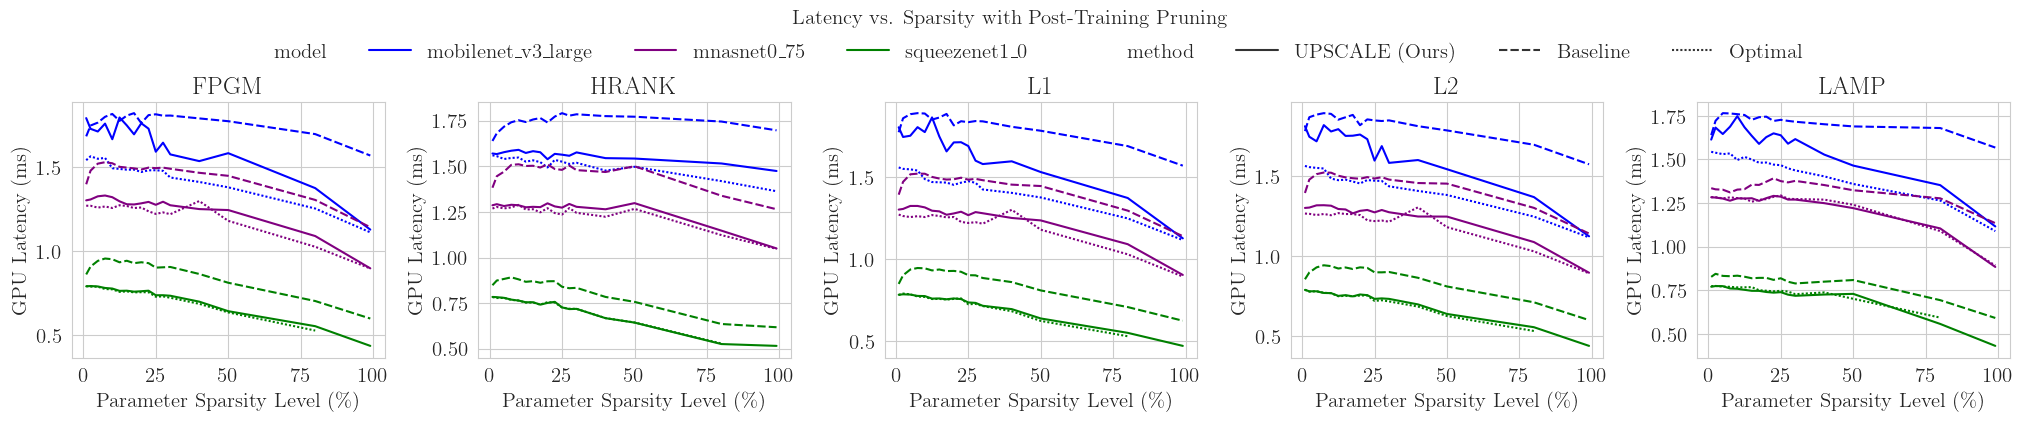

In [251]:
plt.rc('text', usetex=True)
plt.rc('font', family='invalidlol')

# plot accuracies
fig = plt.figure(figsize=(25, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.3, top=0.75)
fig.suptitle('Latency vs. Sparsity with Post-Training Pruning')
size = (1, 5)

df = pd.read_csv(DIRECTORY / 'results.csv')
models = ('mobilenet_v3_large', 'mnasnet0_75', 'squeezenet1_0')

# add new rows for 'gpu_naive_latency_mean' as though it was method='naive'
_df = df[df['method'] == 'unconstrained'].copy()
_df['gpu_latency_mean'] = _df['gpu_naive_latency_mean']
_df['method'] = 'naive'
_df = pd.concat([df, _df], ignore_index=True)
_df['val'] = _df['val'] * 100.0
_df['amount'] = _df['amount'] * 100.0
_df = _df.assign(method=_df.method.map({'unconstrained': 'UPSCALE (Ours)', 'naive': 'Baseline', 'constrained': 'Optimal'}))

heuristics = list(sorted(df['heuristic'].unique()))
for i, heuristic in enumerate(heuristics, start=1):
    ax = fig.add_subplot(*size, i)
    plt.rc('font', size=15)
    plt.rc('figure', titlesize=15)
    plt.rc('legend', fontsize=15)

    condition = (_df['heuristic'] == heuristic) * (_df['side'] == 'input')
    sns.lineplot(_df[condition], x='amount', y='gpu_latency_mean', palette=['blue', 'purple', 'green'], hue='model', hue_order=models, style='method', style_order=('UPSCALE (Ours)', 'Baseline', 'Optimal'), ax=ax, legend=(i > len(heuristics) - 1))
    plt.title(heuristic.upper())
    plt.ylabel('GPU Latency (ms)')
    plt.xlabel('Parameter Sparsity Level (\%)')

    if i > len(heuristics) - 1:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=10, bbox_to_anchor=(0.5, 0.8), frameon=False)
        ax.get_legend().remove()

plt.savefig(directory / f"figure_7_latency_vs_sparsity.pdf", bbox_inches='tight', pad_inches=0)

## Tables

In [221]:
# latencies table

df = df.replace({'fpgm': 'FPGM', 'hrank': 'HRank', 'l1': 'L1', 'l2': 'L2', 'lamp': 'LAMP'})
row_indexer = (
    (df['side'] == 'input')
    * (df['amount'] < 0.5)
)
_df = df[row_indexer]
key_ours = 'Latency (Ours)'
key_naive = 'Latency (Naive)'

_df = _df[[
    'heuristic',
    'amount',
    'model',
    'val',
    'gpu_latency_mean', 'gpu_latency_std',
    'gpu_naive_latency_mean', 'gpu_naive_latency_std'
]].dropna()

HEADER = """\\begin{table}
    \centering
    \\tiny
    \\begin{tabular}{l|l|cccccccccc}
    \\toprule
    Model & Heuristic & Stat & 1\% & 5\% & 10\% & 15\% & 20\% & 25\% & 30\% & 40\% \\\\
"""

def generate_footer(caption, label):
    return f"""
        \\bottomrule
        \end{{tabular}}
        \caption{{ {caption} }}
        \label{{tab:{label}}}
    \end{{table}}"""

def generate_latex(_df, caption, label):
    lines = [HEADER]
    models = _df['model'].unique()
    heuristics = _df['heuristic'].unique()
    table_index = 0
    for model in models:
        # if 'efficientnet' in model:  # place in main paper
        #     continue
        if model in ('mobilenet_v2', 'resnet101', 'squeezenet1_0'):
            lines.append(generate_footer(caption, f"{label}_{table_index}") + HEADER)
            table_index += 1
        lines.append('\midrule')
        lines.append(model.replace('_', '\_') + ' ')
        for i, heuristic in enumerate(heuristics):
            if i > 0:
                lines.append("\cmidrule{2-11}")
            rows = _df[(_df['model'] == model) * (_df['heuristic'] == heuristic)]
            acc_unc = []
            acc_con = []
            lat_ours = []
            lat_naive = []
            lat_zero = []
            for amount in (.01, .05, .1, .15, .2, .25, .3, .4):
                filtered = rows[(rows['amount'] == amount)]
                if len(filtered):
                    row = filtered.iloc[0]
                    acc_unc.append(f"{row['val'] * 100.:.2f}\%")
                    lat_ours.append(f"{row['gpu_latency_mean']:.2f} ± {row['gpu_latency_std']:.3f}")
                    lat_naive.append(f"{row['gpu_naive_latency_mean']:.2f} ± {row['gpu_naive_latency_std']:.3f}")
                else:
                    acc_unc.append('')
                    lat_ours.append('')
                    lat_naive.append('')

                filtered = df[(df['model'] == model) * (df['heuristic'] == heuristic) * (df['amount'] == amount) * df['method'] == 'constrained'][['val', 'gpu_latency_mean', 'gpu_latency_std']]
                if len(filtered):
                    row = filtered.iloc[0]
                    if np.isnan(row['val']):
                        acc_con.append('')
                    else:
                        acc_con.append(f"{row['val'] * 100.:.2f}\%")
                    if np.isnan(row['gpu_latency_mean']):
                        lat_zero.append('')
                    else:
                        lat_zero.append(f"{row['gpu_latency_mean']:.2f} ± {row['gpu_latency_std']:.3f}")
                else:
                    acc_con.append('')
                    lat_zero.append('')
            if not acc_unc:
                continue
            if ''.join(acc_unc):
                lines.append(f"& {heuristic} & Acc (Ours) & {' & '.join(acc_unc)} \\\\")
            if ''.join(acc_con):
                lines.append(f"& & Acc (Cons) & {' & '.join(acc_con)} \\\\")
            if ''.join(lat_ours):
                lines.append(f"& & Lat (Ours) & {' & '.join(lat_ours)} \\\\")
            if ''.join(lat_naive):
                lines.append(f"& & Lat (Naive) & {' & '.join(lat_naive)} \\\\")
            if ''.join(lat_zero):
                lines.append(f"& & Lat (Zero) & {' & '.join(lat_zero)} \\\\")
    lines.append(generate_footer(caption, f"{label}_{table_index}"))
    return '\n'.join(lines)

CAPTION = '\\textbf{UPSCALE accuracy and latency} across architectures, sparsity levels, and heuristics. Notice that latency for ours is comparable to the ideal, zero-copy reference, much lower than the naive export\'s latency. Additionally notice our (unconstrained) accuracy matches or outperforms the baseline constrained accuracy.'
latex = generate_latex(_df, caption=CAPTION, label='upscale_vs_naive_latency')
with open(directory / 'table.tex', 'w') as f:
    f.write(latex)
print(latex)

\begin{table}
    \centering
    \tiny
    \begin{tabular}{l|l|cccccccccc}
    \toprule
    Model & Heuristic & Stat & 1\% & 5\% & 10\% & 15\% & 20\% & 25\% & 30\% & 40\% \\

\midrule
densenet121 
& FPGM & Acc (Ours) & 72.62\% & 71.04\% & 67.03\% & 57.51\% & 42.15\% & 21.57\% & 9.77\% & 1.17\% \\
& & Acc (Cons) & 71.50\% & 55.42\% & 20.77\% & 4.72\% & 1.20\% & 0.47\% & 0.31\% & 0.08\% \\
& & Lat (Ours) & 5.91 ± 0.012 & 5.97 ± 0.006 & 5.89 ± 0.011 & 5.67 ± 0.010 & 5.53 ± 0.007 & 5.39 ± 0.010 & 5.63 ± 0.006 & 5.30 ± 0.003 \\
& & Lat (Naive) & 6.31 ± 0.006 & 6.42 ± 0.011 & 6.33 ± 0.012 & 6.10 ± 0.025 & 5.99 ± 0.007 & 5.82 ± 0.018 & 6.06 ± 0.016 & 5.69 ± 0.006 \\
& & Lat (Zero) & 5.33 ± 0.007 & 5.35 ± 0.012 & 5.23 ± 0.007 & 4.99 ± 0.006 & 4.89 ± 0.013 & 4.69 ± 0.004 &  &  \\
\cmidrule{2-11}
& HRank & Acc (Ours) & 72.04\% & 63.59\% & 40.68\% & 17.95\% & 4.87\% & 1.59\% & 0.62\% & 0.17\% \\
& & Acc (Cons) & 72.36\% & 54.10\% & 17.03\% & 11.95\% & 1.46\% & 0.47\% & 0.11\% & 0.11\% \\
& & Lat 

# Supplementary

## Figures

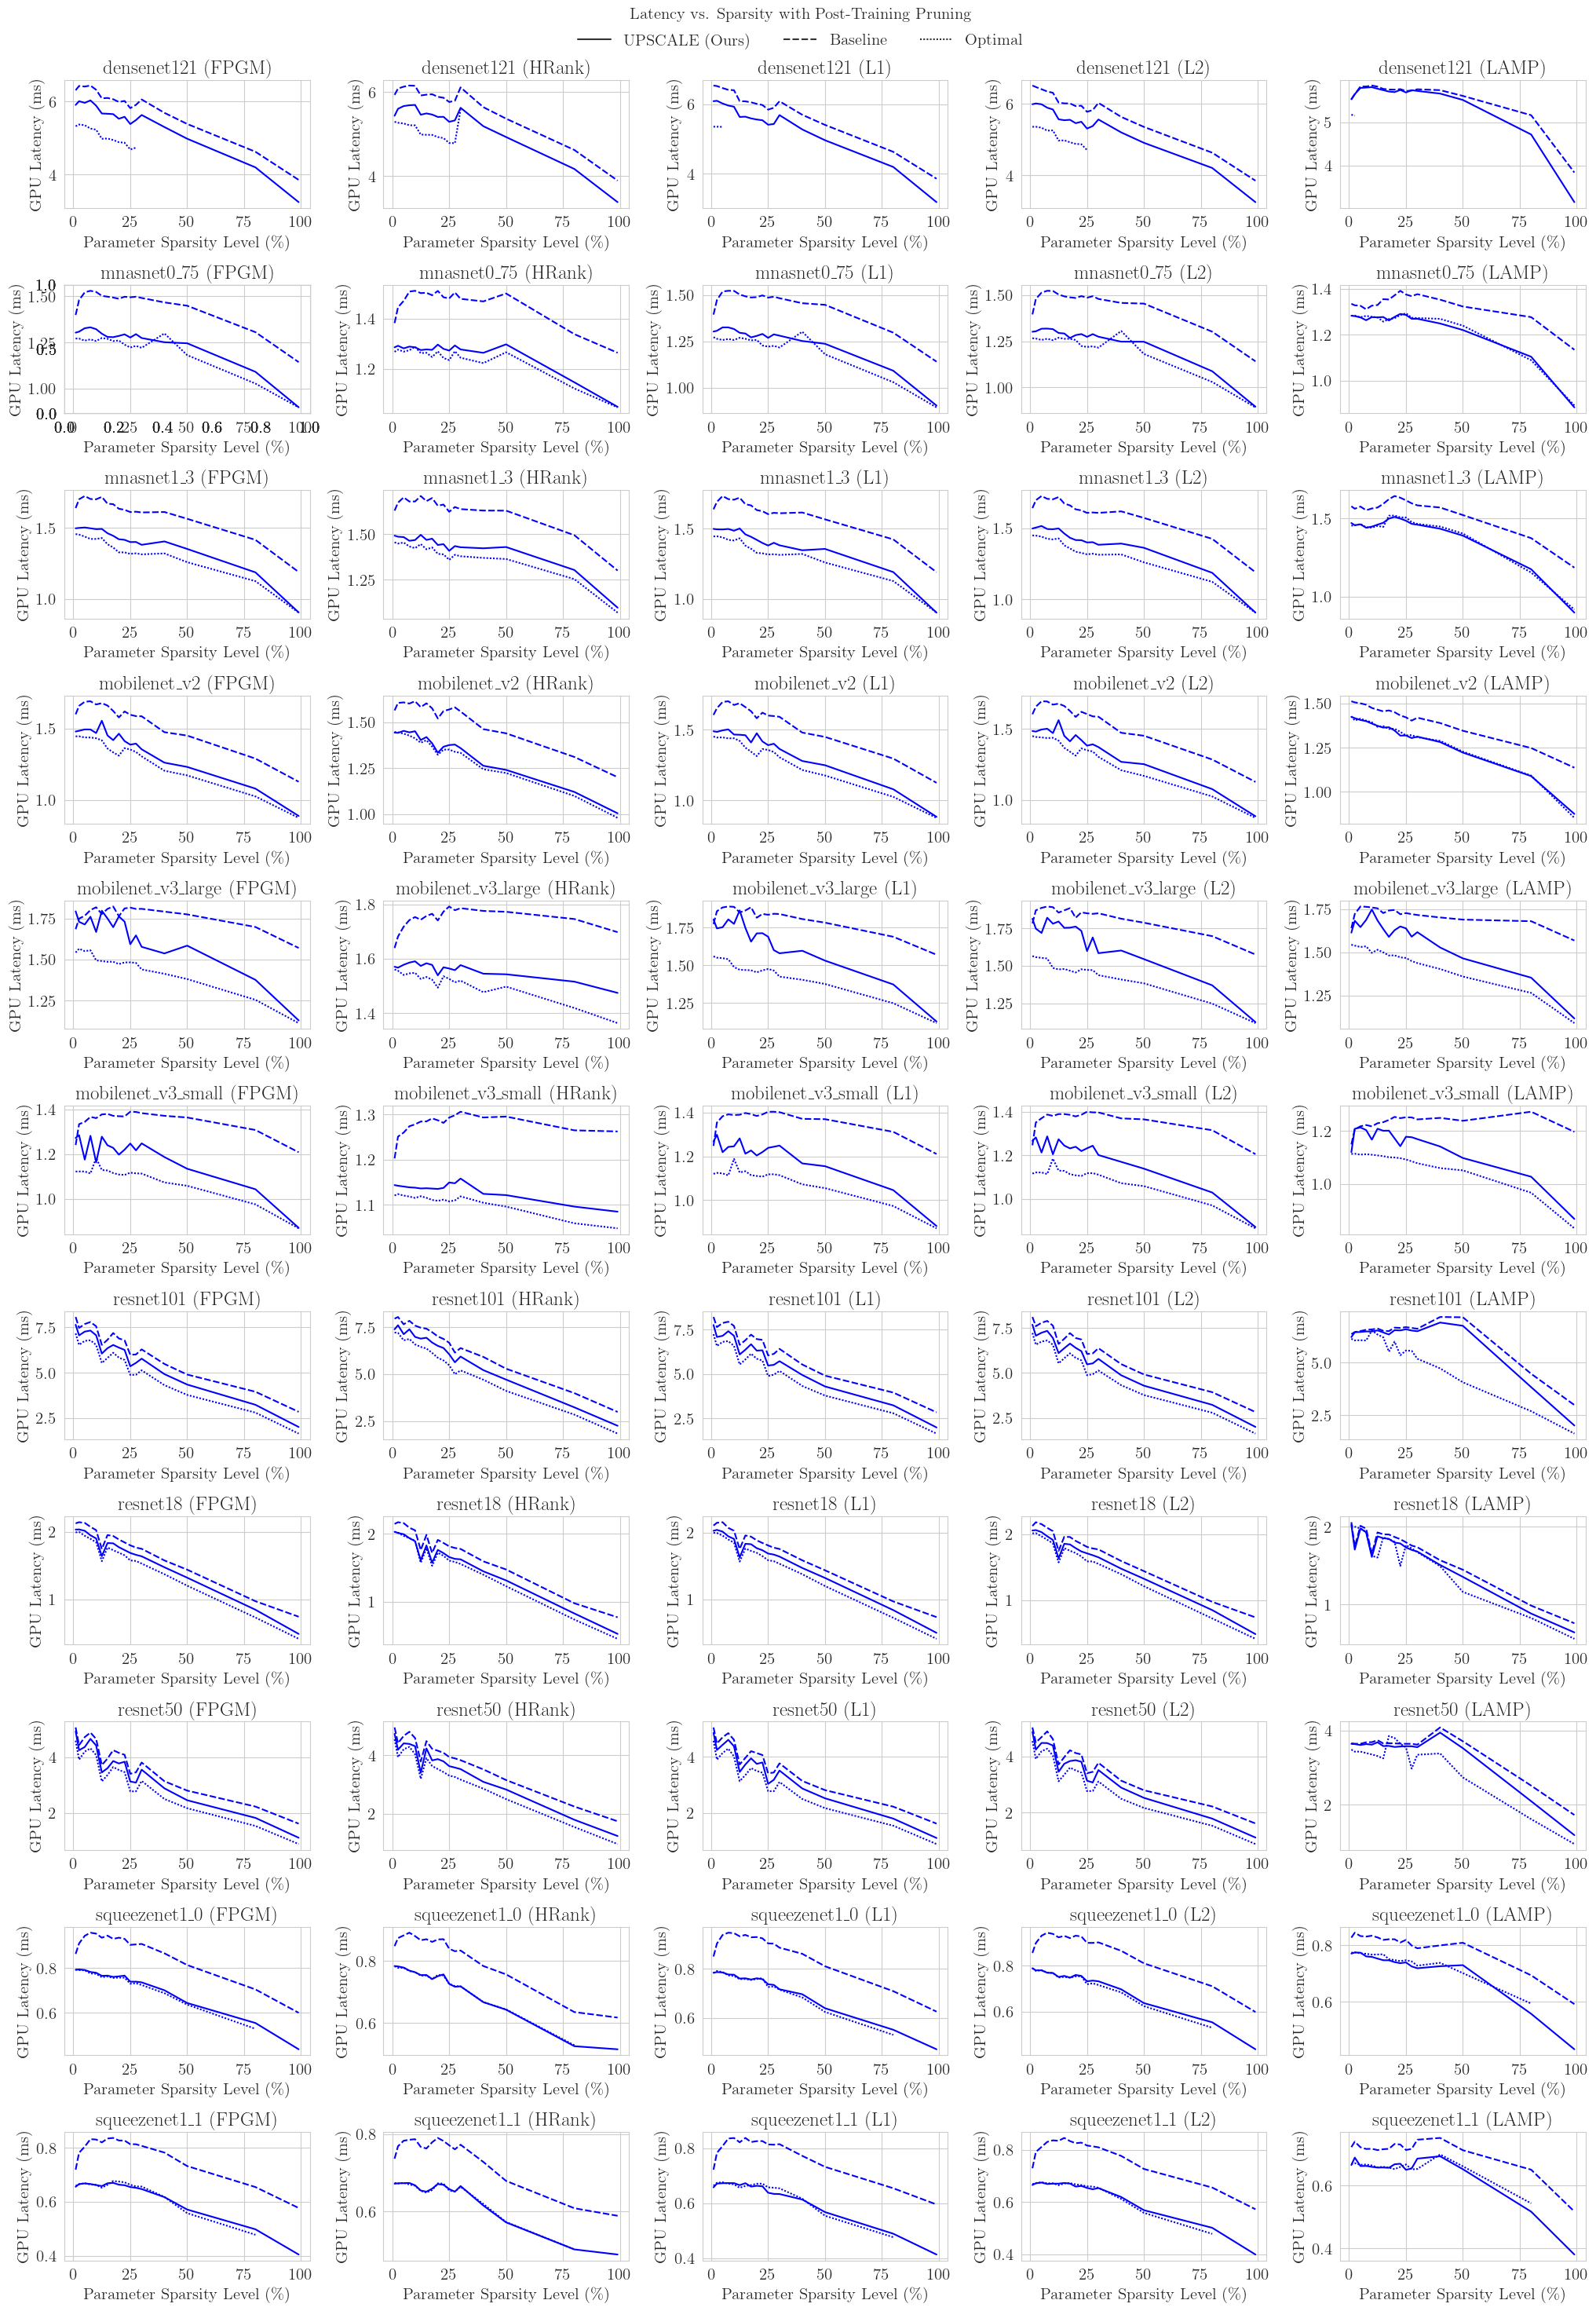

In [96]:
# Sparsity vs. Latency mega-plot

plt.rc('text', usetex=True)
plt.rc('font', family='invalidlol')

df = pd.read_csv(DIRECTORY / 'results.csv')
models = df['model'].unique()

# add new rows for 'gpu_naive_latency_mean' as though it was method='naive'
_df = df[df['method'] == 'unconstrained'].copy()
_df['gpu_latency_mean'] = _df['gpu_naive_latency_mean']
_df['method'] = 'naive'
_df = pd.concat([df, _df], ignore_index=True)
_df['val'] = _df['val'] * 100.0
_df['amount'] = _df['amount'] * 100.0
_df = _df.assign(method=_df.method.map({'unconstrained': 'UPSCALE (Ours)', 'naive': 'Baseline', 'constrained': 'Optimal'}))
_df = _df.assign(heuristic=_df.heuristic.map({'fpgm': 'FPGM', 'hrank': 'HRank', 'l1': 'L1', 'l2': 'L2', 'lamp': 'LAMP'}))

heuristics = list(sorted(_df['heuristic'].unique()))

# plot accuracies
fig = plt.figure(figsize=(25, 3 * len(models)))
fig.subplots_adjust(hspace=0.6, wspace=0.3, top=0.962)
fig.suptitle('Latency vs. Sparsity with Post-Training Pruning')
size = (len(models), len(heuristics))

i = 0
for model in models:
    plt.rc('font', size=15)
    plt.rc('figure', titlesize=15)
    plt.rc('legend', fontsize=15)
    if i > 50:
        break

    try:
        for heuristic in heuristics:
            i += 1
            is_last = i == len(models) * len(heuristic) - 1
            ax = fig.add_subplot(*size, i)
            condition = (_df['heuristic'] == heuristic) * (_df['side'] == 'input') * (_df['model'] == model)
            sns.lineplot(_df[condition], x='amount', y='gpu_latency_mean', style='method', style_order=('UPSCALE (Ours)', 'Baseline', 'Optimal'), ax=ax, legend=is_last, color='blue')
            plt.title(f"{model} ({heuristic})")
            plt.ylabel('GPU Latency (ms)')
            plt.xlabel('Parameter Sparsity Level (\%)')

            if is_last:
                handles, labels = ax.get_legend_handles_labels()
                fig.legend(handles, labels, loc='lower center', ncol=10, bbox_to_anchor=(0.5, 0.966), frameon=False)
                ax.get_legend().remove()
    except:
        ax.clear()
        # if any failures, rewrite the row
        i = i // len(heuristics) * len(heuristic) + 1

plt.savefig(directory / f"supp_latency_vs_sparsity_1.pdf", bbox_inches='tight', pad_inches=0)

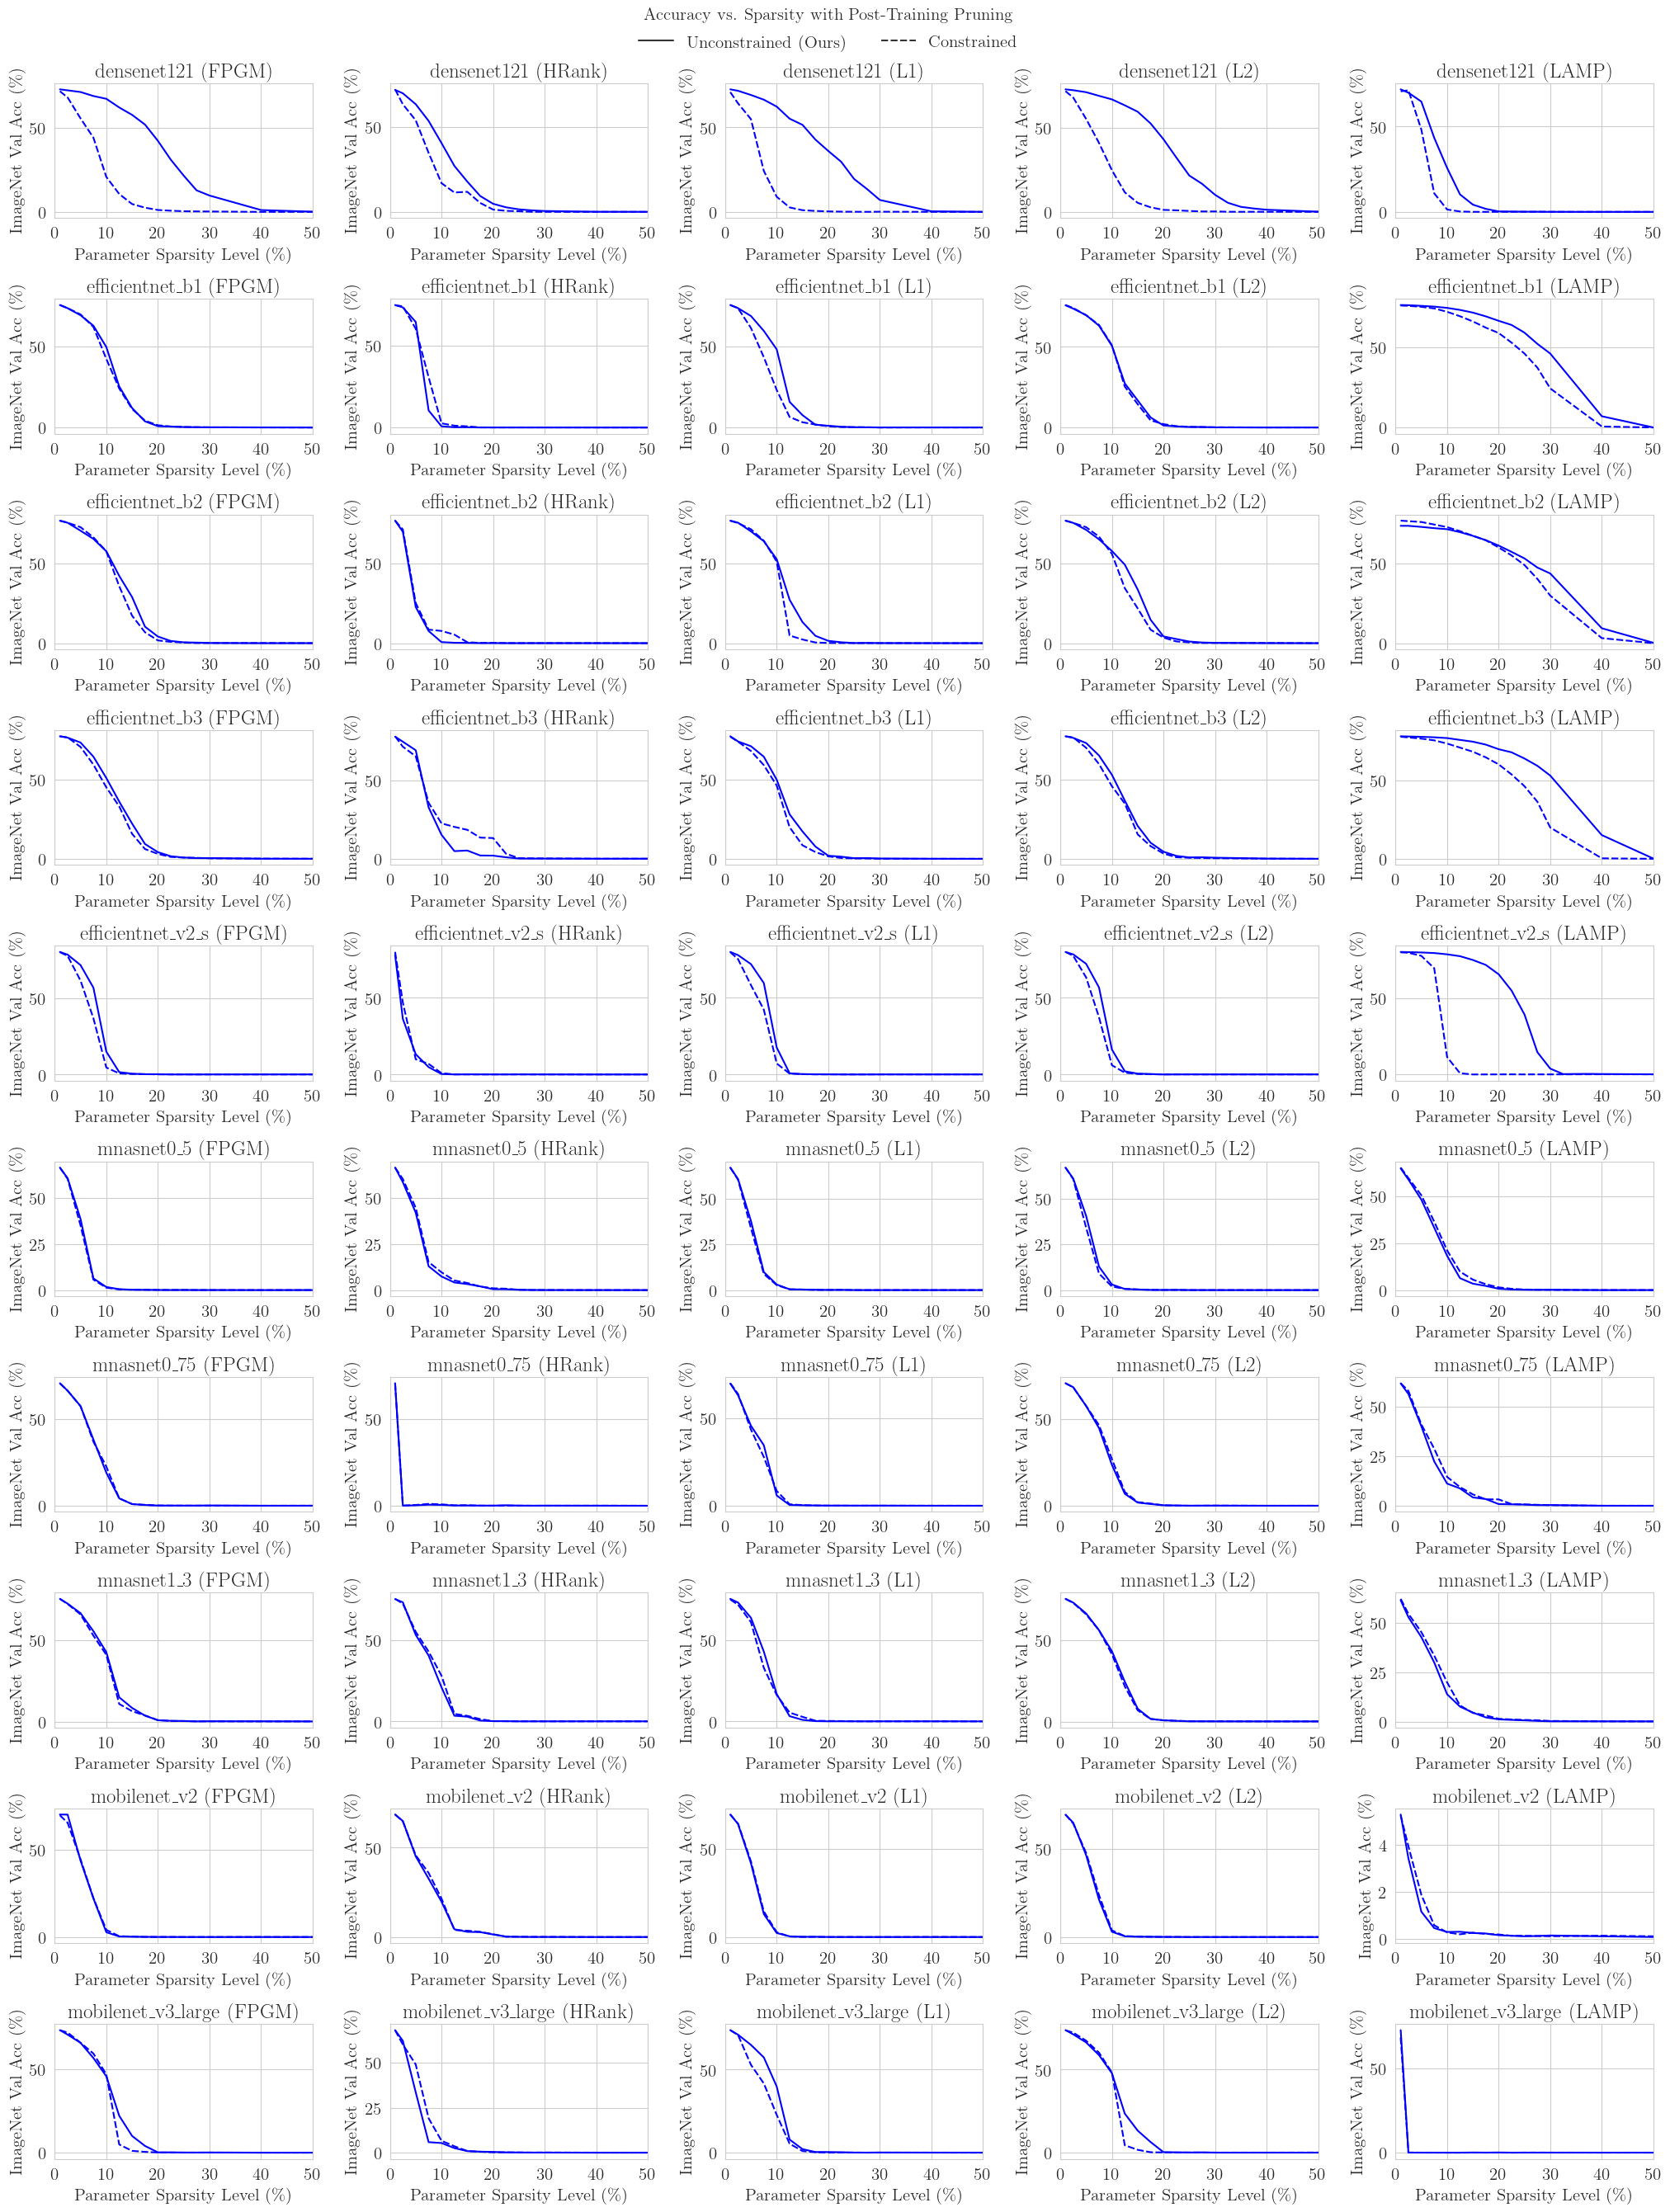

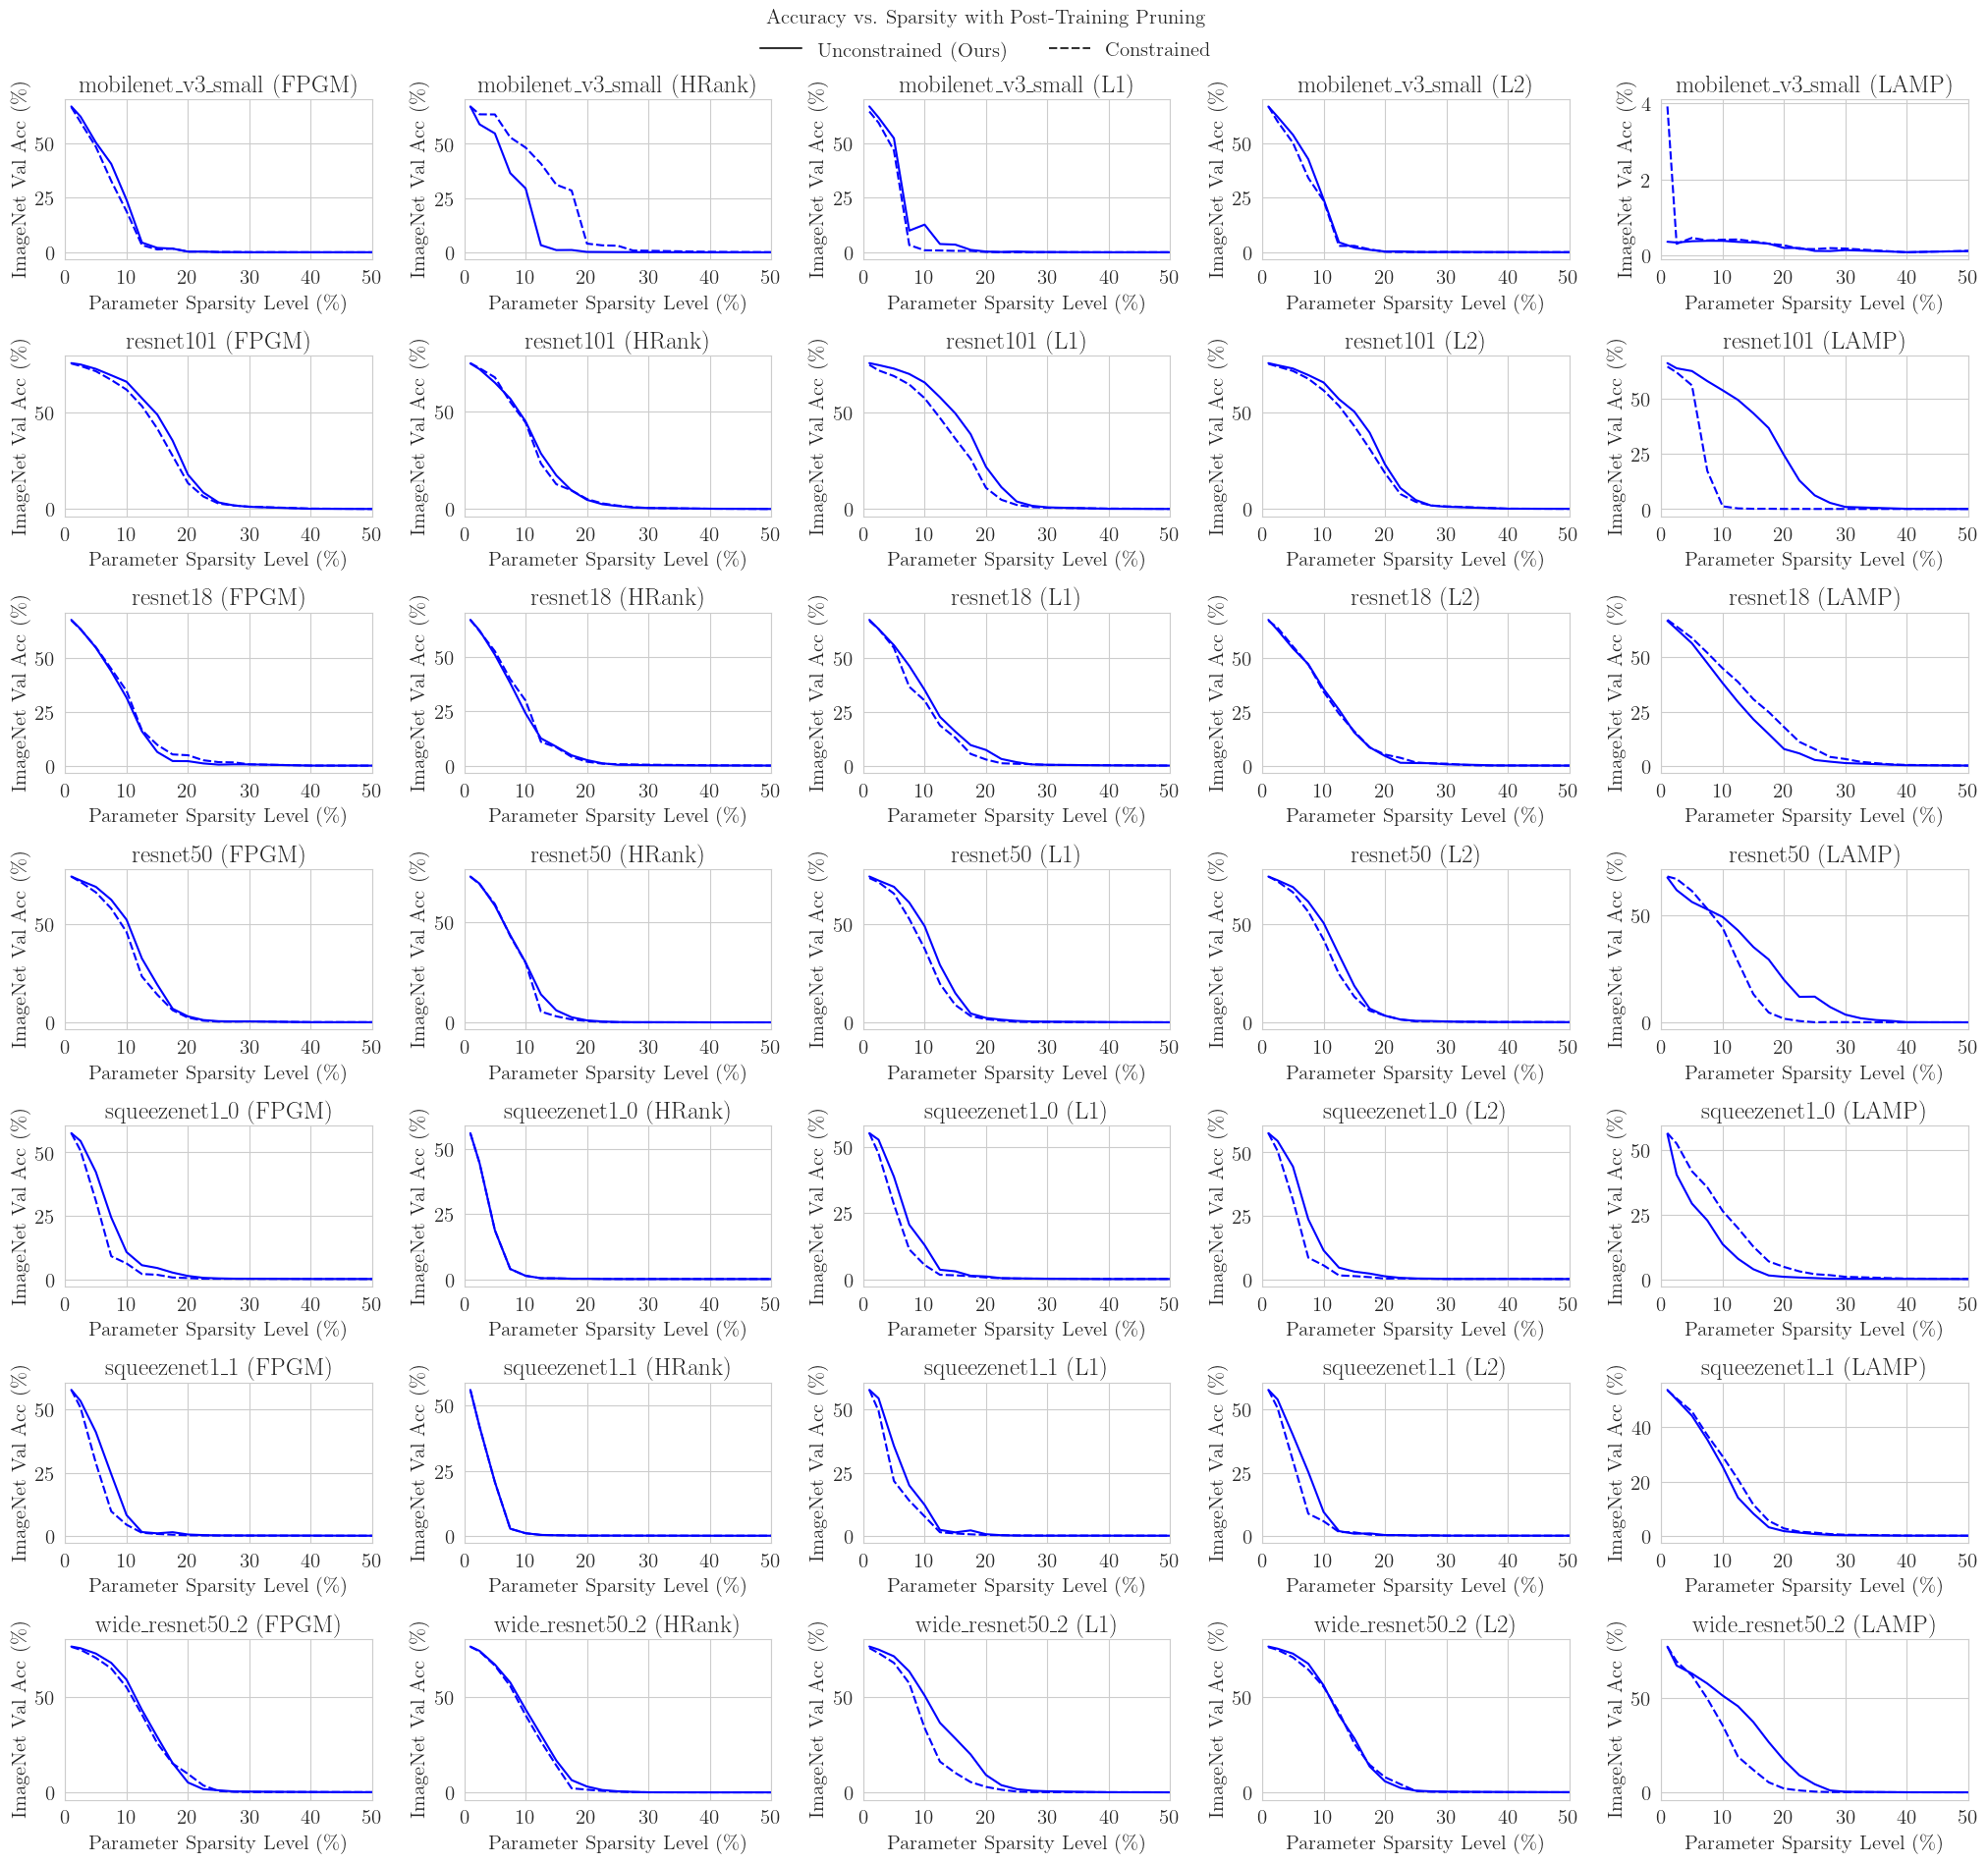

In [95]:
# Sparsity vs. Accuracy mega-plots

plt.rc('text', usetex=True)
plt.rc('font', family='invalidlol')

df = pd.read_csv(DIRECTORY / 'results.csv')
models = df['model'].unique()

# add new rows for 'gpu_naive_latency_mean' as though it was method='naive'
_df = df[df['method'] == 'unconstrained'].copy()
_df['gpu_latency_mean'] = _df['gpu_naive_latency_mean']
_df['method'] = 'naive'
_df = pd.concat([df, _df], ignore_index=True)
_df['val'] = _df['val'] * 100.0
_df['amount'] = _df['amount'] * 100.0
_df = _df.assign(method=_df.method.map({'unconstrained': 'Unconstrained (Ours)', 'constrained': 'Constrained'}))
_df = _df.assign(heuristic=_df.heuristic.map({'fpgm': 'FPGM', 'hrank': 'HRank', 'l1': 'L1', 'l2': 'L2', 'lamp': 'LAMP'}))

heuristics = list(sorted(_df['heuristic'].unique()))

# plot accuracies
fig = plt.figure(figsize=(25, 3 * len(models)))
fig.subplots_adjust(hspace=0.6, wspace=0.3, top=0.962)
fig.suptitle('Accuracy vs. Sparsity with Post-Training Pruning')
size = (len(models), len(heuristics))

i = 0
for model in models:
    plt.rc('font', size=15)
    plt.rc('figure', titlesize=15)
    plt.rc('legend', fontsize=15)
    if i == 50:
        plt.savefig(directory / f"supp_accuracy_vs_sparsity_1.pdf", bbox_inches='tight', pad_inches=0)
        fig = plt.figure(figsize=(25, 3 * len(models)))
        fig.subplots_adjust(hspace=0.6, wspace=0.3, top=0.962)
        fig.suptitle('Accuracy vs. Sparsity with Post-Training Pruning')
        size = (len(models), len(heuristics))
        i -= 50

    try:
        for heuristic in heuristics:
            i += 1
            is_last = i == len(models) * len(heuristic) - 1
            ax = fig.add_subplot(*size, i)
            ax.set_xlim(0, 50)
            condition = (_df['heuristic'] == heuristic) * (_df['side'] == 'input') * (_df['model'] == model)
            sns.lineplot(_df[condition], x='amount', y='val', style='method', style_order=('Unconstrained (Ours)', 'Constrained'), ax=ax, legend=is_last, color='blue')
            plt.title(f"{model} ({heuristic})")
            plt.ylabel('ImageNet Val Acc (\%)')
            plt.xlabel('Parameter Sparsity Level (\%)')

            if is_last:
                handles, labels = ax.get_legend_handles_labels()
                fig.legend(handles, labels, loc='lower center', ncol=10, bbox_to_anchor=(0.5, 0.966), frameon=False)
                ax.get_legend().remove()
    except:
        ax.clear()
        # if any failures, rewrite the row
        i = i // len(heuristics) * len(heuristic) + 1

plt.savefig(directory / f"supp_accuracy_vs_sparsity_2.pdf", bbox_inches='tight', pad_inches=0)

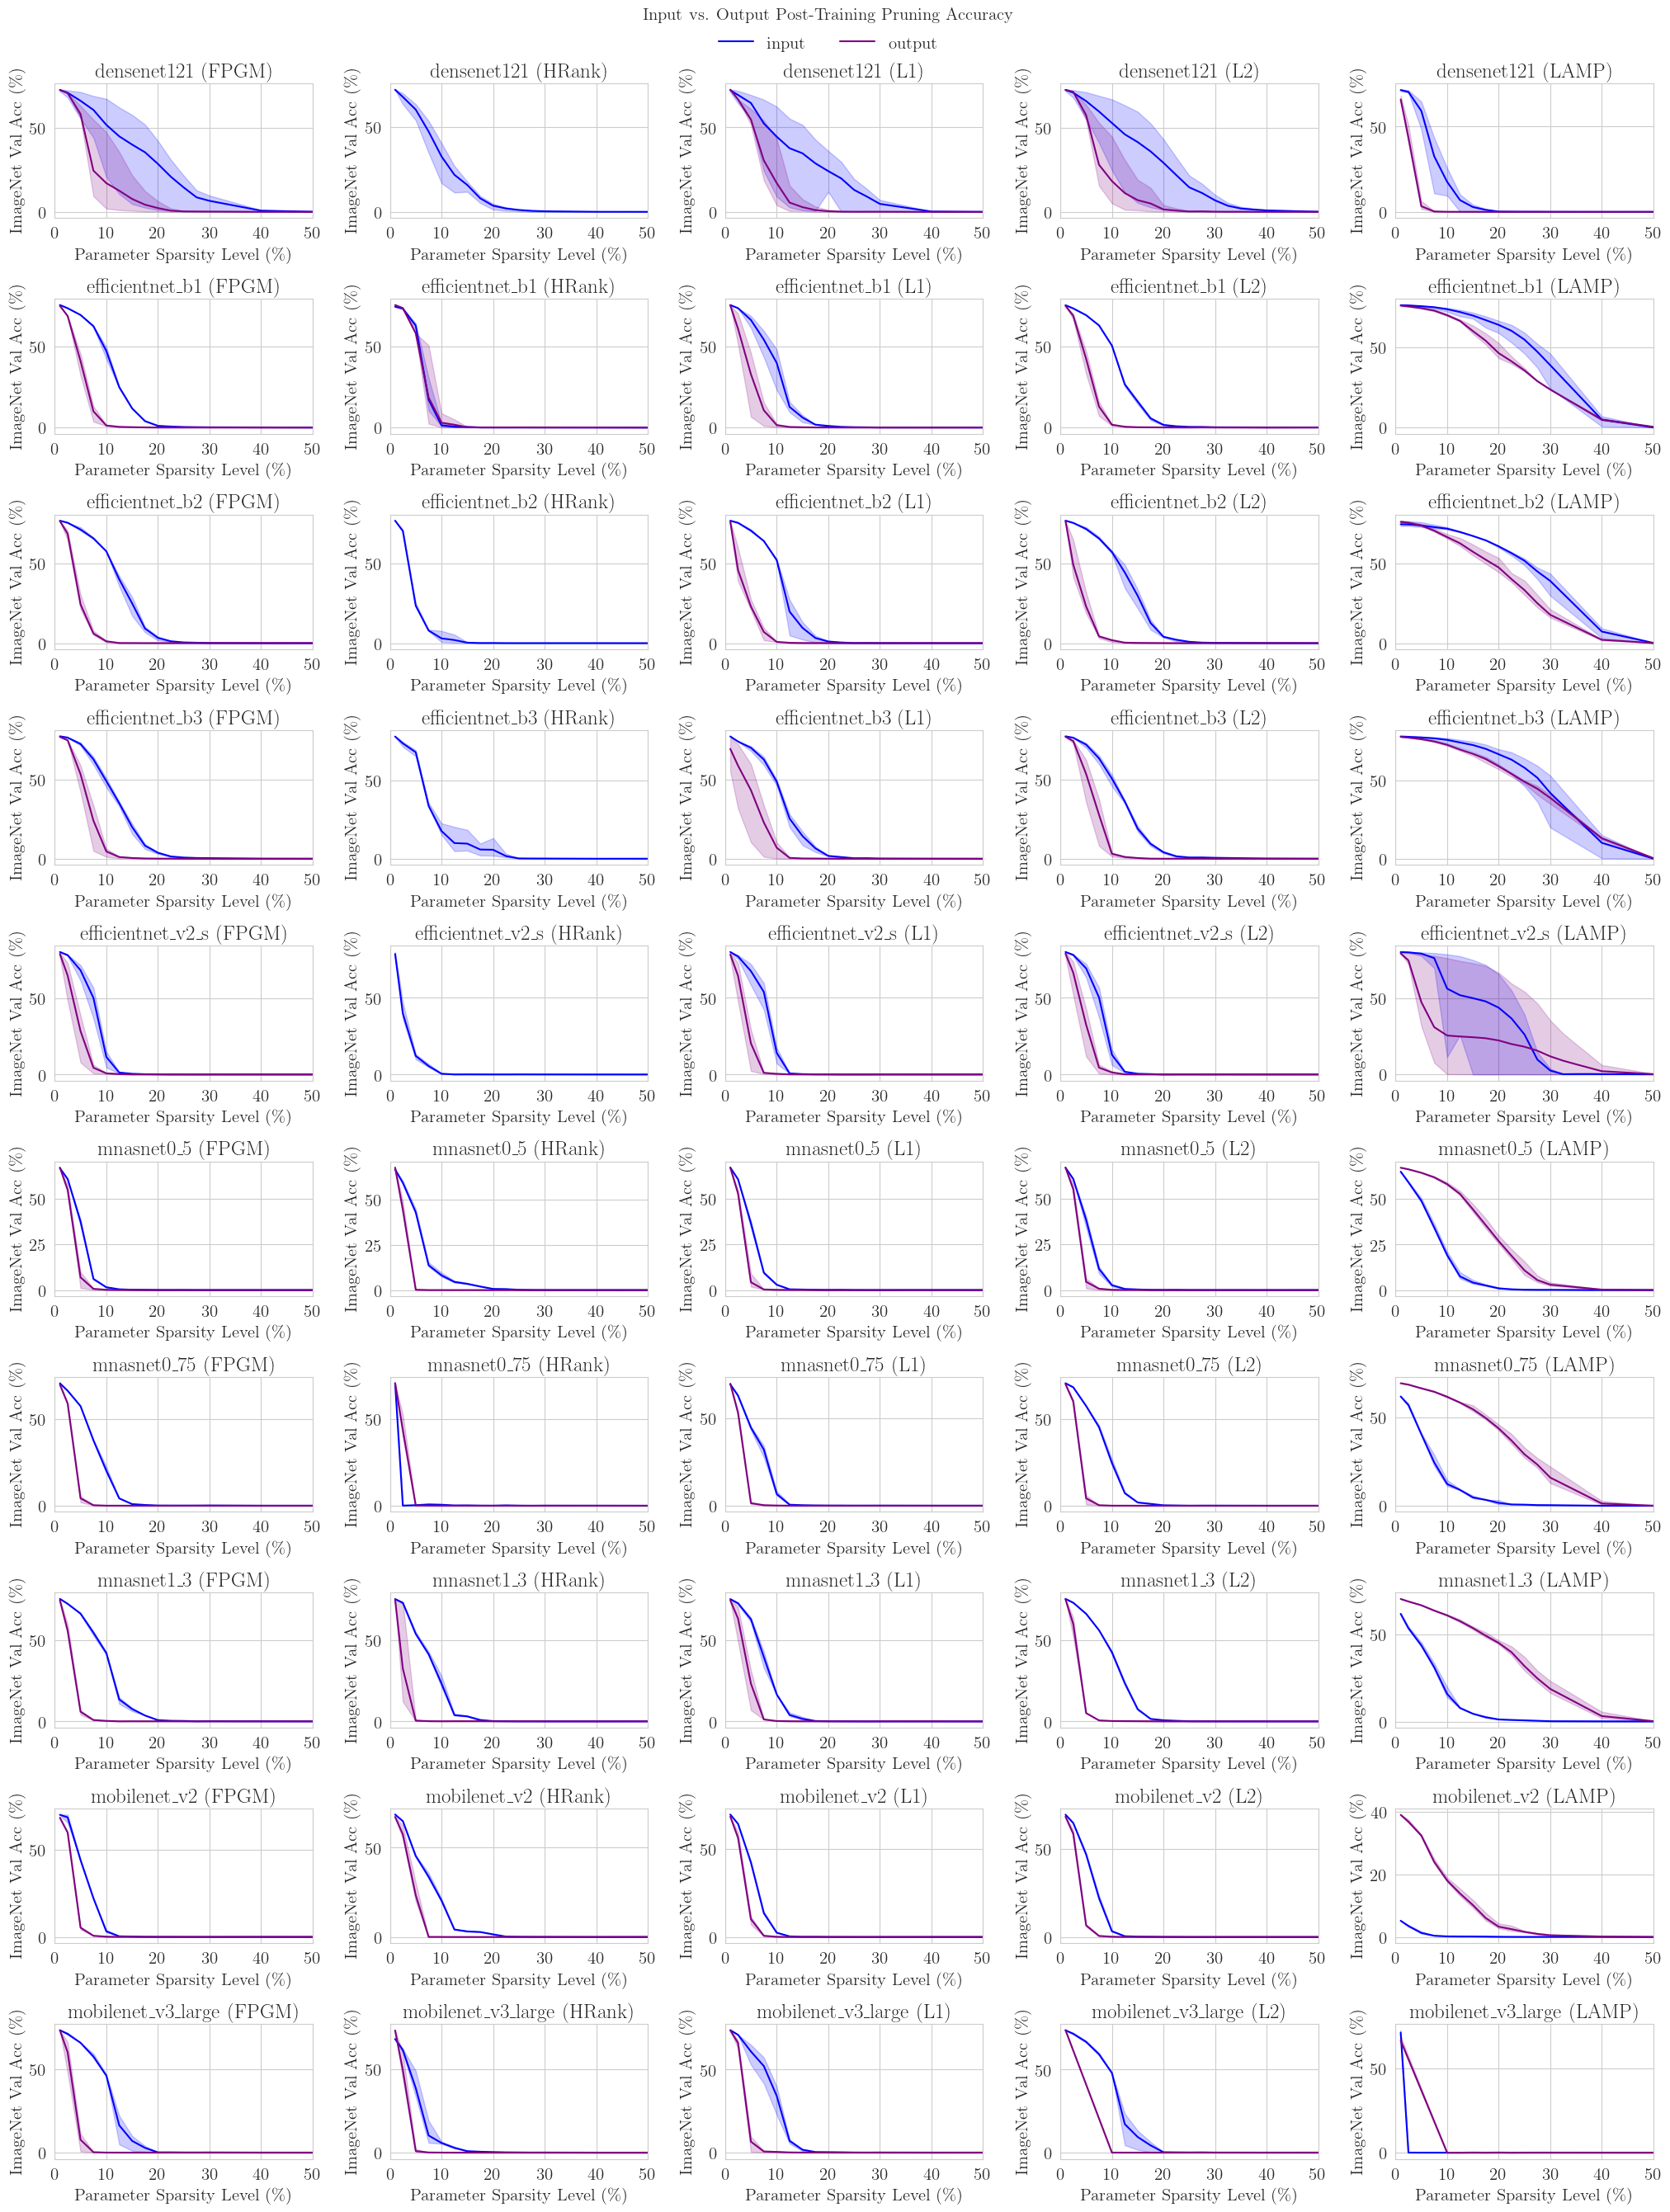

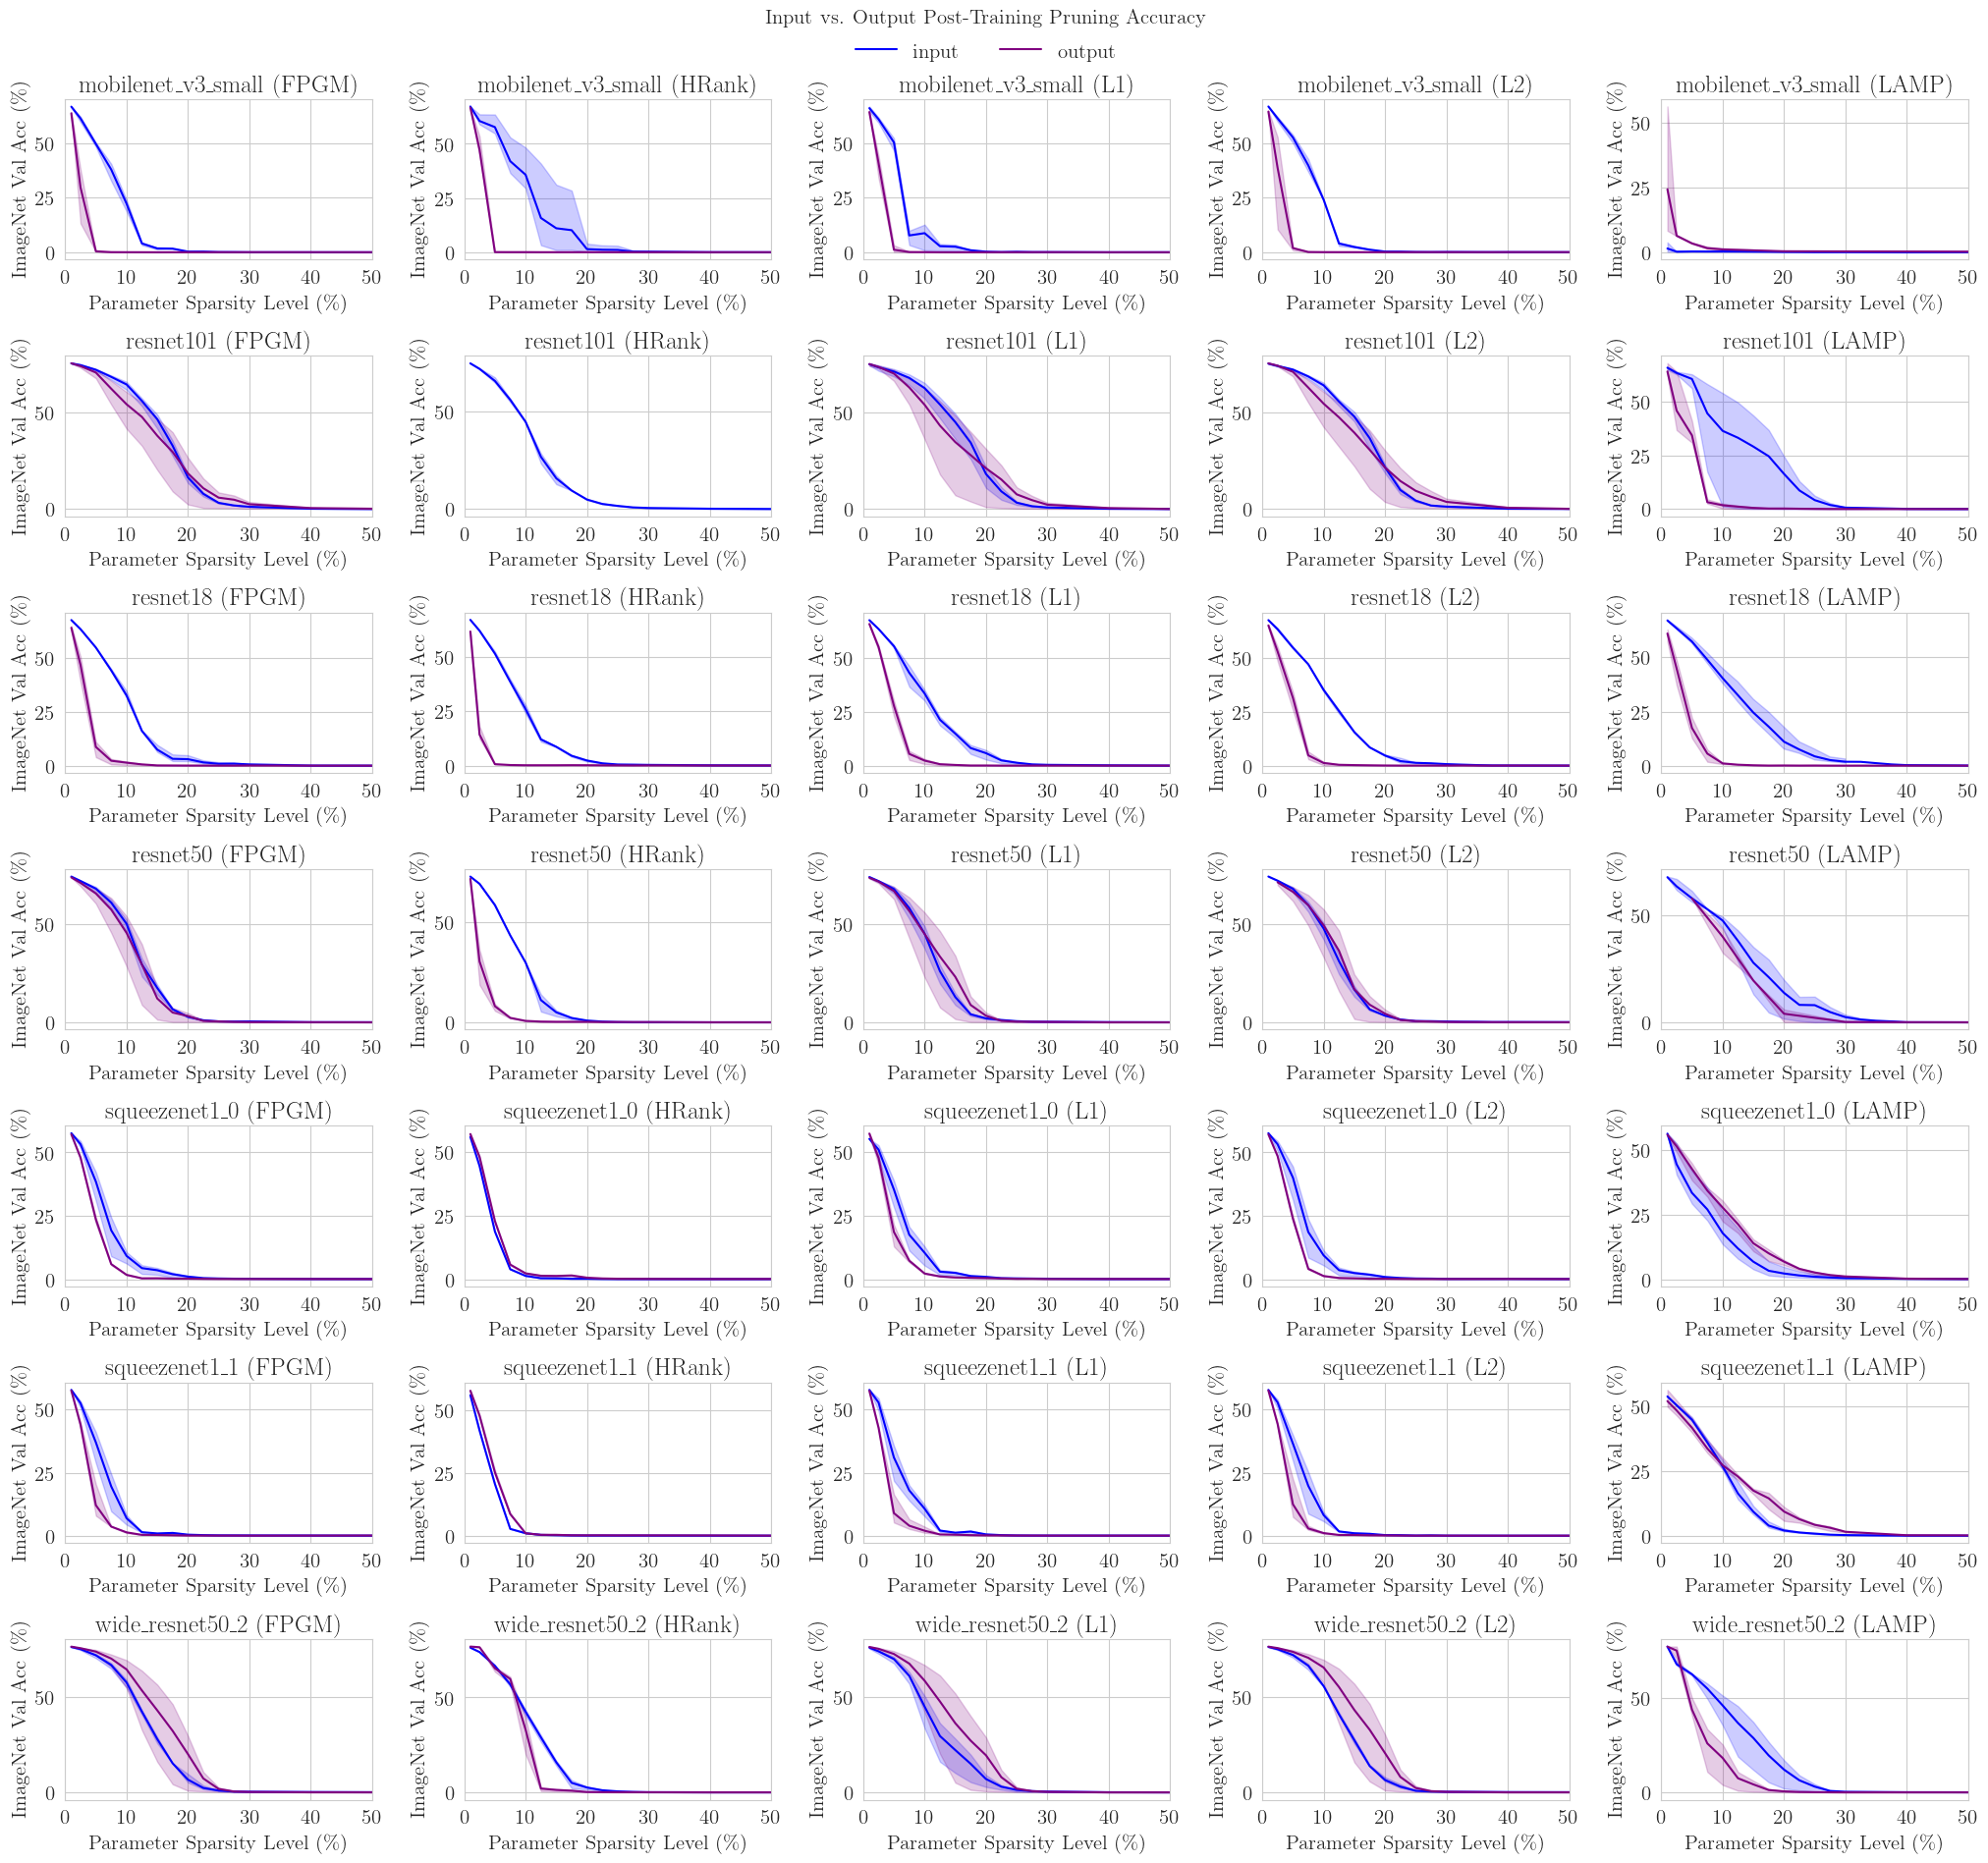

In [67]:
# Sparsity vs. Accuracy mega-plots

plt.rc('text', usetex=True)
plt.rc('font', family='invalidlol')

df = pd.read_csv(DIRECTORY / 'results.csv')
models = df['model'].unique()

# add new rows for 'gpu_naive_latency_mean' as though it was method='naive'
_df = df[df['method'] == 'unconstrained'].copy()
_df['gpu_latency_mean'] = _df['gpu_naive_latency_mean']
_df['method'] = 'naive'
_df = pd.concat([df, _df], ignore_index=True)
_df['val'] = _df['val'] * 100.0
_df['amount'] = _df['amount'] * 100.0
_df = _df.assign(method=_df.method.map({'unconstrained': 'Unconstrained (Ours)', 'constrained': 'Constrained'}))
_df = _df.assign(heuristic=_df.heuristic.map({'fpgm': 'FPGM', 'hrank': 'HRank', 'l1': 'L1', 'l2': 'L2', 'lamp': 'LAMP'}))

heuristics = list(sorted(_df['heuristic'].unique()))

# plot accuracies
fig = plt.figure(figsize=(25, 3 * len(models)))
fig.subplots_adjust(hspace=0.6, wspace=0.3, top=0.962)
fig.suptitle('Input vs. Output Post-Training Pruning Accuracy')
size = (len(models), len(heuristics))

i = 0
for model in models:
    plt.rc('font', size=15)
    plt.rc('figure', titlesize=15)
    plt.rc('legend', fontsize=15)
    if i == 50:
        plt.savefig(directory / f"supp_input_vs_output_accuracy_1.pdf", bbox_inches='tight', pad_inches=0)
        fig = plt.figure(figsize=(25, 3 * len(models)))
        fig.subplots_adjust(hspace=0.6, wspace=0.3, top=0.962)
        fig.suptitle('Input vs. Output Post-Training Pruning Accuracy')
        size = (len(models), len(heuristics))
        i -= 50

    try:
        for heuristic in heuristics:
            i += 1
            is_last = i == len(models) * len(heuristic) - 1
            ax = fig.add_subplot(*size, i)
            ax.set_xlim(0, 50)
            condition = (_df['heuristic'] == heuristic) * (_df['model'] == model)
            sns.lineplot(_df[condition], x='amount', y='val', hue='side', hue_order=('input', 'output'), palette=['blue', 'purple'], ax=ax, legend=is_last)
            plt.title(f"{model} ({heuristic})")
            plt.ylabel('ImageNet Val Acc (\%)')
            plt.xlabel('Parameter Sparsity Level (\%)')

            if is_last:
                handles, labels = ax.get_legend_handles_labels()
                fig.legend(handles, labels, loc='lower center', ncol=10, bbox_to_anchor=(0.5, 0.966), frameon=False)
                ax.get_legend().remove()
    except:
        ax.clear()
        # if any failures, rewrite the row
        i = i // len(heuristics) * len(heuristic) + 1

plt.savefig(directory / f"supp_input_vs_output_accuracy_2.pdf", bbox_inches='tight', pad_inches=0)

# Supp (Extra Experiments)

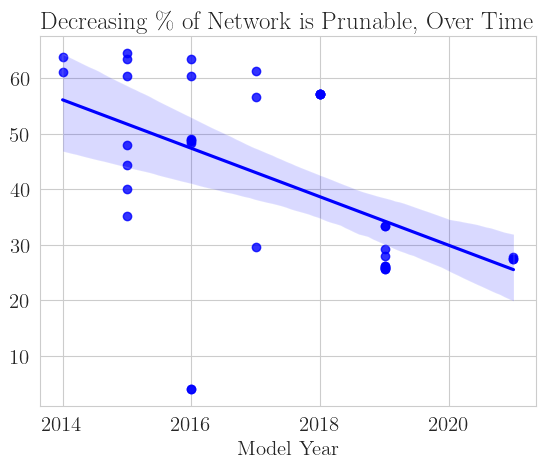

In [91]:
plt.title('Decreasing \% of Network is Prunable, Over Time')
fig1 = pd.read_csv('data/prunable.csv', skiprows=2)
fig1['% simple consumers'] = 100 - fig1['% complex consumers']
plot = sns.regplot(data=fig1, x='year', y='% simple consumers', color='blue')
fig = plot.get_figure()
plt.ylabel('% Convolutions in "Simple" Segments')
plt.xlabel('Model Year')
plt.savefig('data/supp_time_convs.pdf')

6.575105032121931

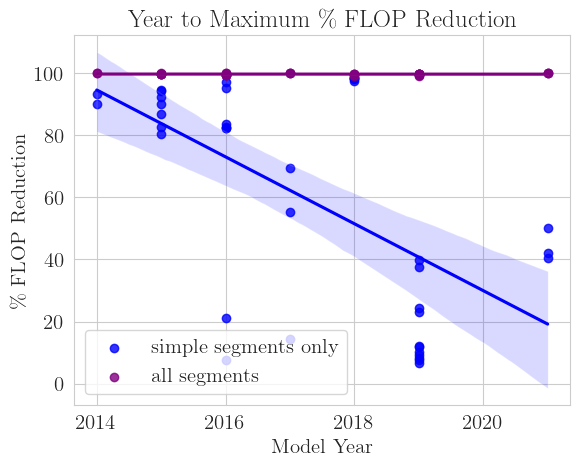

In [92]:
# plot max flop reduction over time
flops = pd.read_csv('data/flops.csv')
flops['simple_flop_reduction'] = (1.0 - (flops['simple_flops'] / flops['og_flops'])) * 100.0
flops['all_flop_reduction'] = (1.0 - (flops['our_flops'] / flops['og_flops'])) * 100.0
flops = pd.merge(flops, fig1[['model', 'year']], on='model')
plot = sns.regplot(data=flops, x='year', y='simple_flop_reduction', label='simple segments only', color='blue')
plot = sns.regplot(data=flops, x='year', y='all_flop_reduction', label='all segments', color='purple')
plt.legend()
plt.title('Year to Maximum \% FLOP Reduction')
plt.ylabel('\% FLOP Reduction')
plt.xlabel('Model Year')
plt.savefig('data/supp_time_flops.pdf')
flops['simple_flop_reduction'].min()

In [82]:
years = pd.read_csv('data/years.csv', skiprows=2)[['model', 'year']]
cols = [col for col in 'original_mean,original_std,naive_mean,naive_std,simple_mean,simple_std,our_mean,our_std,og_flops,naive_flops,simple_flops,our_flops,win % (lat),win x (lat),win % (flops),win x (flops)'.split(',') if 'std' not in col]
results = None
for i, percent in enumerate((10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99)):
    result = pd.read_csv(f"data/results-random-{percent}.csv")[['model'] + cols]
    if results is None:
        results = result
    else:
        results = results.join(result, rsuffix=f".{i}")
    results[f"percent.{i}"] = percent
results = results.dropna().rename(columns={col: f"{col}.0" for col in cols})
df = results.merge(years, on='model')
df.head()

model  original_mean.0  naive_mean.0  simple_mean.0  our_mean.0   
0      densenet121           16.296        17.168         16.202      16.244  \
1      densenet161           18.756        20.524         19.508      19.328   
2      densenet169           27.584        28.030         27.096      26.830   
3      densenet201           32.148        32.822         31.834      31.340   
4  efficientnet_b0            3.852         4.756          3.634       4.324   

   og_flops.0  naive_flops.0  simple_flops.0  our_flops.0  win % (lat).0  ...   
0      2.8990         2.5314          2.6604       2.5220           5.38  ...  \
1      7.8489         6.7782          7.1946       6.7568           5.83  ...   
2      3.4381         2.9933          3.1631       2.9835           4.28  ...   
3      4.3924         3.7868          4.0349       3.7752           4.52  ...   
4      0.4067         0.3333          0.3658       0.3313           9.08  ...   

   og_flops.10  naive_flops.10  simple_flops.10  our_flops.10 win % (lat).10   
0       2.8990          0.0613           0.5171        0.0194          26.15  \
1       7.8489          0.1179           1.2801        0.0298          22.79   
2       3.4381          0.0661           0.5943        0.0187          19.12   
3       4.3924          0.0928           0.7840        0.0331          17.38   
4       0.4067          0.0378           0.3081        0.0014          80.00   

  win x (lat).10  win % (flops).10 win x (flops).10  percent.10  year  
0            1.4             68.35              3.2          99  2016  
1            1.3             74.72              4.0          99  2016  
2            1.2             71.71              3.5          99  2016  
3            1.2             64.33              2.8          99  2016  
4            5.0             96.30             27.0          99  2019  

[5 rows x 155 columns]

In [83]:
means = df[[f'win % (lat).{i}' for i in range(1, 11)]].median(axis=1)
years = df['year']
year_to_mean = pd.concat([years, means], axis=1).dropna().sort_values(by='year').rename(columns={0: 'mean'})
year_to_mean.head()

year   mean
27  2015  18.33
26  2015  22.95
25  2015  17.90
24  2015  13.93
23  2015  14.18

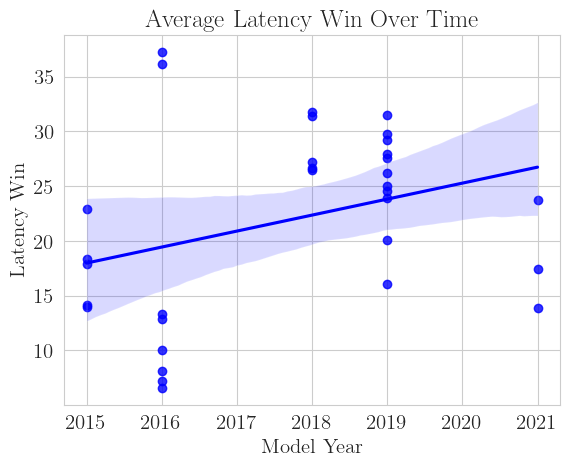

In [93]:
# figure - lawl, not very helpful. TODO: instead, plot latency win vs. unpruned for simple-only vs. complex
plot = sns.regplot(data=year_to_mean, x='year', y='mean', color='blue')
plt.title('Average Latency Win Over Time')
plt.xlabel('Model Year')
plt.ylabel('Latency Win %')
plt.savefig('data/supp_time_win.pdf')

4.81927710843374


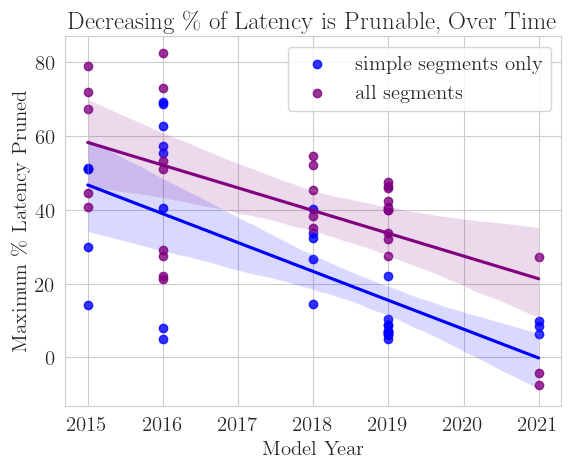

In [94]:
# plot max latency reduction over time
df[['simple_mean.10', 'original_mean.10', 'our_mean.10']] = df[['simple_mean.10', 'original_mean.10', 'our_mean.10']].astype(float)
df['simple_latency_reduction'] = (1.0 - (df['simple_mean.10'] / df['original_mean.10'])) * 100.0
df['all_latency_reduction'] = (1.0 - (df['our_mean.10'] / df['original_mean.10'])) * 100.0
plot = sns.regplot(data=df, x='year', y='simple_latency_reduction', label='simple segments only', color='blue')
plot = sns.regplot(data=df, x='year', y='all_latency_reduction', label='all segments', color='purple')
plt.legend()
plt.title('Decreasing \% of Latency is Prunable, Over Time')
plt.ylabel('Maximum \% Latency Pruned')
plt.xlabel('Model Year')
plt.savefig('data/supp_time_latency.pdf')
print(df['simple_latency_reduction'].min())
# df[['model', 'simple_latency_reduction']]

In [385]:
def get_table_for_latency(rows, columns, verbose=True):
    cols = ['model', 'original_mean.0']
    col_mapping = {}
    for i in columns:
        cols.extend([f'naive_mean.{i}', f'our_mean.{i}', f'win % (lat).{i}'])
    result = df[cols].round(decimals=1).filter(items=rows, axis=0).dropna()
    if verbose:
        print(result.to_latex(index=False))
    return result

get_table_for_latency(rows=[0, 4, 14, 16, 21, 22, 23, 25, 28], columns=[1, 3, 5, 7, 9])

\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
             model &  original\_mean.0 &  naive\_mean.1 &  our\_mean.1 &  win \% (lat).1 &  naive\_mean.3 &  our\_mean.3 &  win \% (lat).3 &  naive\_mean.5 &  our\_mean.5 &  win \% (lat).5 &  naive\_mean.7 &  our\_mean.7 &  win \% (lat).7 &  naive\_mean.9 &  our\_mean.9 &  win \% (lat).9 \\
\midrule
       densenet121 &             16.3 &          16.3 &        15.4 &            5.2 &          13.5 &        12.6 &            6.4 &          11.4 &        10.4 &            9.0 &           8.3 &         7.1 &           13.8 &          11.0 &         9.2 &           17.0 \\
   efficientnet\_b0 &              3.9 &           4.5 &         4.0 &           10.8 &           4.3 &         3.4 &           21.2 &           4.1 &         3.2 &           21.8 &           4.6 &         2.8 &           39.5 &           5.7 &         2.4 &           58.4 \\
 efficientnet\_v2\_s &              9.5 &          11.6 &        12.1 &           -3.7 &          11.0

/var/folders/z2/vlhc7yzs4jl3f9xj_tyw1mkr0000gn/T/ipykernel_2502/518310025.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(result.to_latex(index=False))


model  original_mean.0  naive_mean.1  our_mean.1  \
0          densenet121             16.3          16.3        15.4   
4      efficientnet_b0              3.9           4.5         4.0   
14   efficientnet_v2_s              9.5          11.6        12.1   
16          mnasnet0_5              1.8           2.4         1.8   
21  mobilenet_v3_large              2.5           3.4         2.4   
22  mobilenet_v3_small              1.8           2.2         2.0   
23           resnet101             12.0          14.2        12.9   
25            resnet18              3.2           3.8         3.4   
28       squeezenet1_0              1.5           1.9         1.4   

    win % (lat).1  naive_mean.3  our_mean.3  win % (lat).3  naive_mean.5  \
0             5.2          13.5        12.6            6.4          11.4   
4            10.8           4.3         3.4           21.2           4.1   
14           -3.7          11.0        10.0            8.5          10.6   
16           24.0           2.3         1.7           25.4           2.2   
21           28.6           3.3         2.4           25.4           3.2   
22            9.9           2.4         1.8           27.0           2.3   
23            9.6          11.3         9.7           14.1           9.8   
25           11.1           2.8         2.5            8.3           2.7   
28           28.1           1.8         1.3           29.4           1.7   

    our_mean.5  win % (lat).5  naive_mean.7  our_mean.7  win % (lat).7  \
0         10.4            9.0           8.3         7.1           13.8   
4          3.2           21.8           4.6         2.8           39.5   
14         8.3           22.1          10.4         6.7           35.6   
16         1.6           25.4           2.6         1.5           41.5   
21         2.3           28.7           3.0         2.0           34.8   
22         1.7           27.2           3.0         1.6           48.6   
23         8.6           12.7           8.2         7.0           14.2   
25         2.0           24.2           1.7         1.4           17.4   
28         1.2           33.9           1.6         1.0           36.1   

    naive_mean.9  our_mean.9  win % (lat).9  
0           11.0         9.2           17.0  
4            5.7         2.4           58.4  
14          15.3         6.5           57.5  
16           3.4         1.4           59.5  
21           4.8         1.7           65.3  
22           4.3         1.3           69.0  
23           7.3         5.2           29.5  
25           2.1         1.0           52.3  
28           2.7         0.8           71.4

In [386]:
get_table_for_latency(rows=range(100), columns=range(11), verbose=False)[[f'win % (lat).{i}' for i in range(11)]].max().max()

84.6

In [486]:
def plot_model(i, model):
    ax = fig.add_subplot(*size, i)
    row = df[df['model'] == model]  # lol probably a better way to do this instead of jankily doing it per row 
    naive_mean = row[[f"naive_mean.{i}" for i in range(11)]].to_numpy()[0]
    our_mean = row[[f"our_mean.{i}" for i in range(11)]].to_numpy()[0]
    percents = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]
    mnv3 = pd.DataFrame([naive_mean, our_mean, percents, ]).transpose().rename(columns={0: 'naive_lat', 1: 'our_lat', 2: 'percent'})
    sns.lineplot(data=mnv3, x='percent', y='naive_lat', label='naive', ax=ax)
    sns.lineplot(data=mnv3, x='percent', y='our_lat', label='ours', ax=ax)

    mnv3['original_mean'] = float(row['original_mean.0'])
    sns.lineplot(data=mnv3, x='percent', y='original_mean', label='original')

    plt.ylabel('Latency (ms)')
    plt.xlabel('Percent channels pruned')
    plt.title(model)
    plt.legend()

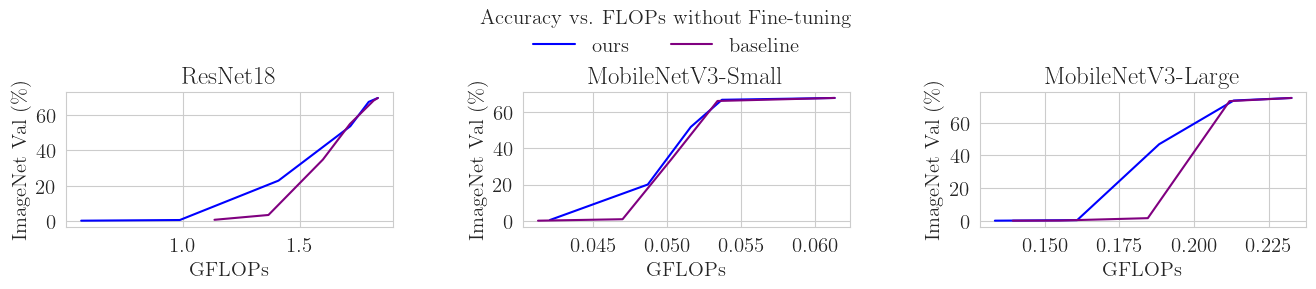

In [140]:
fig = plt.figure(figsize=(16, 2.5))
fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.65)
fig.suptitle('Accuracy vs. FLOPs without Fine-tuning')
size = (1, 3)
exps = {
    'r18': pd.DataFrame([
        (0.0, 69.76, 0., 1.83, 'ours'),
        (0.0, 69.76001, 0., 1.83001, 'baseline'),
        (0.01, 68.27, 13.64, 1.8121, 'baseline'),
        (0.05, 55.00, 14.81, 1.7113, 'baseline'),
        (0.1, 34.80, 13.86, 1.5961, 'baseline'),
        (0.2, 3.37, 27.76, 1.3644, 'baseline'),
        (0.3, 0.64, 28.31, 1.1346, 'baseline'),
        (0.01, 67.53, 27.79, 1.7911, 'ours'),
        (0.05, 53.70, 29.26, 1.7126, 'ours'),
        (0.1, 22.85, 27.60, 1.407, 'ours'),
        (0.2, 0.51, 27.52, 0.9871, 'ours'),
        (0.3, 0.13, 24.91, 0.5673, 'ours'),
    ], columns=['percent', 'accuracy', 'latency (ms)', 'GFLOPs', 'method']),
    'mbv3s': pd.DataFrame([
        (0.00, 67.668, 6.02, 0.0613, 'ours'),
        (0.00, 67.6680001, 6.02, 0.0613, 'baseline'),
        (0.01, 66.67, 5.19, 0.0537, 'ours'),
        (0.01, 66.01, 16.07, 0.0534, 'baseline'),
        (0.05, 51.71, 5.54, 0.0516, 'ours'),
        (0.05, 34.04, 15.74, 0.0503, 'baseline'),
        (0.1, 20.0, 11.17, 0.0487, 'ours'),
        (0.1, 0.89, 16.39, 0.047, 'baseline'),
        (0.2, 0.45, 26.44, 0.0421, 'ours'),
        (0.2, 0.08, 15.98, 0.0413, 'baseline'),
    ], columns=['percent', 'accuracy', 'latency (ms)', 'GFLOPs', 'method']),
    'mbv3l': pd.DataFrame([
        (0.00, 75.274, 0.0, 0.2327, 'ours'),
        (0.00, 75.2740001, 0.0, 0.2327, 'baseline'),
        (0.01, 73.70, 0.0, 0.2133, 'ours'),
        (0.01, 73.34, 0.0, 0.2119, 'baseline'),
        (0.1, 46.91, 0.0, 0.1883, 'ours'),
        (0.1, 1.56, 0.0, 0.1845, 'baseline'),
        (0.2, 0.35, 0.0, 0.1608, 'ours'),
        (0.2, 0.09, 0.0, 0.1548, 'baseline'),
        (0.3, 0.017, 0.0, 0.1332, 'ours'),
        (0.3, 0.010, 0.0, 0.1392, 'baseline'),
    ], columns=['percent', 'accuracy', 'latency (ms)', 'GFLOPs', 'method']),
}
# exps['efv2s'] = exps['mbv3l']
for i, (key, name) in enumerate([
    ('r18', 'ResNet18'),
    ('mbv3s', 'MobileNetV3-Small'),
    ('mbv3l', 'MobileNetV3-Large'),
    # ('efv2s', 'EfficientNetV2-Small'),
], start=1):
    ax = fig.add_subplot(*size, i)
    plt.locator_params(nbins=5)
    sns.lineplot(data=exps[key], x='GFLOPs', y='accuracy', hue='method', ax=ax, legend=i > 2, palette=('blue', 'purple'))
    plt.ylabel('ImageNet Val (\%)')
    plt.xlabel('GFLOPs')
    plt.title(name)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=10, bbox_to_anchor=(0.5, 0.72), frameon=False)
ax.get_legend().remove()
plt.savefig(f"data/supp_single_vs_multi_noft_flops.pdf", bbox_inches='tight', transparent="True", pad_inches=0)
plt.show()
plt.close()

In [141]:
NET_NAME_KEYS = [
    ('r18', 'ResNet18', 'resnet18'),
    ('mbv3s', 'MobileNetV3-Small', 'mobilenet_v3_small'),
    ('mbv3l', 'MobileNetV3-Large', 'mobilenet_v3_large'),
    # ('efv2s', 'EfficientNetV2-Small', 'efficientnet_v2_s')
]

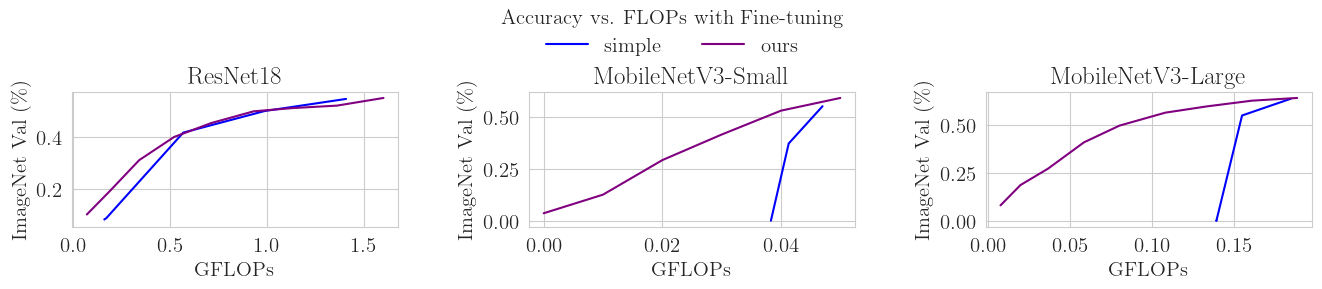

In [142]:
fig = plt.figure(figsize=(16, 2.5))
fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.65)
fig.suptitle('Accuracy vs. FLOPs with Fine-tuning')
size = (1, 3)
exps_ft = {}
for i, (net, name, _) in enumerate(NET_NAME_KEYS, start=1):   
    ax = fig.add_subplot(*size, i)
    data = pd.read_csv(f"data/results-{net}.csv")
    exps_ft[net] = data
    sns.lineplot(data=data, x='simple_flops', y='validation_acc_ft_simple', label='simple', ax=ax, color='blue', legend=False)
    sns.lineplot(data=data, x='our_flops', y='validation_acc_ft_ours', label='ours', errorbar=None, ax=ax, color='purple', legend=False)
    if i > 2:
        plt.legend()
    plt.xlabel('GFLOPs')
    plt.ylabel('ImageNet Val (\%)')
    plt.title(name)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=10, bbox_to_anchor=(0.5, 0.72), frameon=False)
ax.get_legend().remove()
plt.savefig(f"data/supp_single_vs_multi_ft_flops.pdf", bbox_inches='tight', transparent="True", pad_inches=0)
plt.show()
plt.close()

In [137]:
tmp_global = None
for (key, name, _) in NET_NAME_KEYS:
    tmp = exps_ft[key].copy()
    tmp['percent'] = [f"{i * 10}%" for i in range(1, 10)]
    for key in ('ours', 'simple'):
        tmp[f"validation_acc_ft_{key}"] = round(tmp[f"validation_acc_ft_{key}"] * 100.0, 2)
    cols = ['percent', 'our_flops', 'validation_acc_ft_ours', 'simple_flops', 'validation_acc_ft_simple']
    tmp = tmp[cols] \
        .set_index('percent')
    tmp2 = pd.DataFrame([
        ['Segments', 'All (ours)', 'All (ours)', 'Simple', 'Simple'],
        ['Model', name, name, name, name],
    ], columns=cols)
    tmp = pd.concat([tmp2, tmp]) \
        .transpose() \
        .rename({
            'our_flops': 'FLOPs',
            'validation_acc_ft_ours': 'Acc',
            'simple_flops': 'FLOPs',
            'validation_acc_ft_simple': 'Acc'
        }).reset_index() \
        .rename(columns={
            0: 'Segments',
            1: 'Model',
            'index': 'Stat'
        }) \
        .dropna() \
        .set_index('Model')
    if tmp_global is None:
        tmp_global = tmp
    else:
        tmp_global = pd.concat([tmp_global, tmp])
print(tmp_global.to_latex(float_format="{:0.2f}".format))
tmp_global

\begin{tabular}{llllllllllll}
\toprule
 & Stat & Segments & 10% & 20% & 30% & 40% & 50% & 60% & 70% & 80% & 90% \\
Model &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
ResNet18 & FLOPs & All (ours) & 1.60 & 1.36 & 1.13 & 0.93 & 0.71 & 0.52 & 0.34 & 0.19 & 0.07 \\
ResNet18 & Acc & All (ours) & 54.88 & 51.94 & 51.00 & 49.75 & 45.24 & 39.94 & 31.07 & 19.34 & 10.27 \\
ResNet18 & FLOPs & Simple & 1.41 & 0.99 & 0.57 & 0.17 & 0.16 & 0.16 & 0.16 & 0.16 & 0.16 \\
ResNet18 & Acc & Simple & 54.50 & 49.87 & 41.61 & 8.77 & 8.28 & 7.49 & 8.38 & 8.64 & 9.23 \\
MobileNetV3-Small & FLOPs & All (ours) & 0.05 & 0.04 & 0.04 & 0.03 & 0.02 & 0.02 & 0.01 & 0.01 & 0.00 \\
MobileNetV3-Small & Acc & All (ours) & 59.32 & 55.06 & 51.34 & 41.67 & 34.46 & 24.20 & 15.30 & 10.03 & 3.68 \\
MobileNetV3-Small & FLOPs & Simple & 0.05 & 0.04 & 0.04 & 0.04 & 0.04 & 0.04 & 0.04 & 0.04 & 0.04 \\
MobileNetV3-Small & Acc & Simple & 55.33 & 37.35 & 0.10 & 0.15 & 0.11 & 0.10 & 0.10 & 0.11 & 0.12 \\
MobileNetV3-Large & FLOPs & All 

Stat    Segments       10%       20%       30%   
Model                                                                   
ResNet18              FLOPs  All (ours)       1.6      1.36      1.13  \
ResNet18                Acc  All (ours)     54.88     51.94      51.0   
ResNet18              FLOPs      Simple     1.407    0.9871    0.5673   
ResNet18                Acc      Simple      54.5     49.87     41.61   
MobileNetV3-Small     FLOPs  All (ours)      0.05      0.04      0.04   
MobileNetV3-Small       Acc  All (ours)     59.32     55.06     51.34   
MobileNetV3-Small     FLOPs      Simple     0.047    0.0413    0.0383   
MobileNetV3-Small       Acc      Simple     55.33     37.35       0.1   
MobileNetV3-Large     FLOPs  All (ours)  0.188329  0.160814  0.133216   
MobileNetV3-Large       Acc  All (ours)     64.23     62.82     59.81   
MobileNetV3-Large     FLOPs      Simple    0.1845    0.1548    0.1392   
MobileNetV3-Large       Acc      Simple     63.84     55.08      0.13   
EfficientNetV2-Small  FLOPs  All (ours)  2.470956  2.078289  1.691264   
EfficientNetV2-Small    Acc  All (ours)     67.92     66.25     65.53   
EfficientNetV2-Small  FLOPs      Simple    2.2382    1.6111    1.4319   
EfficientNetV2-Small    Acc      Simple      67.4     59.85      0.27   

                           40%       50%       60%       70%       80%   
Model                                                                    
ResNet18                  0.93      0.71      0.52      0.34      0.19  \
ResNet18                 49.75     45.24     39.94     31.07     19.34   
ResNet18                0.1693    0.1603    0.1603    0.1603    0.1603   
ResNet18                  8.77      8.28      7.49      8.38      8.64   
MobileNetV3-Small         0.03      0.02      0.02      0.01      0.01   
MobileNetV3-Small        41.67     34.46      24.2      15.3     10.03   
MobileNetV3-Small       0.0383    0.0383    0.0383    0.0383    0.0383   
MobileNetV3-Small         0.15      0.11       0.1       0.1      0.11   
MobileNetV3-Large     0.108071  0.080229  0.058572  0.036742  0.020004   
MobileNetV3-Large        56.55     49.79     41.03      27.3     18.75   
MobileNetV3-Large       0.1392    0.1392    0.1392    0.1392    0.1392   
MobileNetV3-Large         0.14      0.16      0.16      0.14      0.16   
EfficientNetV2-Small  1.336737  0.983814  0.685594  0.408247  0.192093   
EfficientNetV2-Small     62.77     59.66     54.16      44.8     33.36   
EfficientNetV2-Small    1.4319    1.4319    1.4319    1.4319    1.4319   
EfficientNetV2-Small      0.32      0.33      0.31      0.31      0.28   

                           90%  
Model                           
ResNet18                  0.07  
ResNet18                 10.27  
ResNet18                0.1603  
ResNet18                  9.23  
MobileNetV3-Small          0.0  
MobileNetV3-Small         3.68  
MobileNetV3-Small       0.0383  
MobileNetV3-Small         0.12  
MobileNetV3-Large     0.007852  
MobileNetV3-Large         8.14  
MobileNetV3-Large       0.1392  
MobileNetV3-Large         0.16  
EfficientNetV2-Small  0.056619  
EfficientNetV2-Small     20.04  
EfficientNetV2-Small    1.4319  
EfficientNetV2-Small      0.31

KeyError: "None of [Index(['simple_mean.0', 'simple_mean.1', 'simple_mean.2', 'simple_mean.3',\n       'simple_mean.4', 'simple_mean.5', 'simple_mean.6', 'simple_mean.7',\n       'simple_mean.8'],\n      dtype='object')] are in the [columns]"

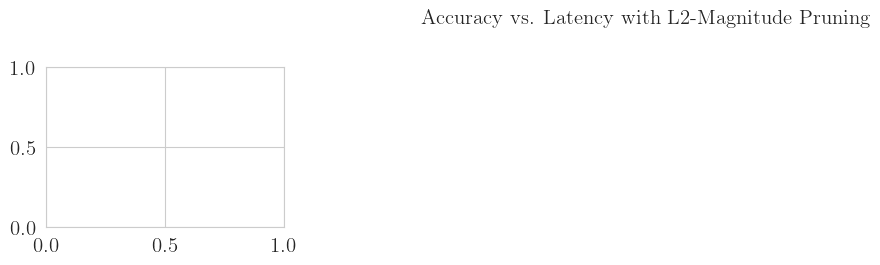

In [138]:
# NOTE: does not work lol
fig = plt.figure(figsize=(16, 2.5))
fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.75)
fig.suptitle('Accuracy vs. Latency with L2-Magnitude Pruning')
size = (1, 4)
# exps_ft = {}
for i, (net, name, key) in enumerate(NET_NAME_KEYS, start=1):   
    ax = fig.add_subplot(*size, i)
    data = pd.read_csv(f"data/results-{net}.csv")
    exps_ft[net] = data
    
    # integrate updated latency stats from main df
    row = df[df['model'] == key]
    data['simple_mean'] = row[[f"simple_mean.{i}" for i in range(9)]].to_numpy()[0]
    data['our_mean'] = row[[f"our_mean.{i}" for i in range(9)]].to_numpy()[0]  # bc idk how to properly use pandas lol
 
    # cast to float
    cols = ['simple_mean', 'our_mean', 'validation_acc_ft_simple', 'validation_acc_ft_ours']
    data[cols] = data[cols].astype(float)
    
    sns.regplot(data=data, x='simple_mean', y='validation_acc_ft_simple', label='simple', ax=ax, color='blue', legend=False)
    sns.regplot(data=data, x='our_mean', y='validation_acc_ft_ours', label='ours', ax=ax, color='purple', legend=False)
    if i > 3:
        plt.legend()
    plt.xlabel('Latency (ms)')
    plt.ylabel('ImageNet Val (\%)')
    plt.title(name)
    _, high = ax.get_ylim()
    ax.set_ylim((0, high))
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=10, bbox_to_anchor=(0.5, 0.72), frameon=False)
ax.get_legend().remove()
plt.savefig(f"out/supp_single_vs_multi_ft_latency.pdf", bbox_inches='tight', transparent="True", pad_inches=0)
plt.show()
plt.close()